# Creación del modelo de Car Parts:

En el siguiente notebook se encuentra todo el código para el entrenamiento del modelo de detección de partes de vehículos. Se incluyen explicaciones, pero la explicación detallada se encuentra en la memoria del proyecto.

## Preparación del entorno.

### Instalación de dependencias:

In [3]:
!pip install kagglehub

!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless

!pip install ultralytics
!pip install pyyaml

!apt-get install -y libgl1-mesa-dev
!apt-get install -y libglib2.0-0

Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


### Importación de librerías:

In [4]:
import kagglehub
import cv2
import random
import json
import os
import shutil
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import zipfile

from ultralytics import YOLO

### Definición de funciones:

Función que se usará para pasar a zip las carpetas que contienen los resultados de los tuning, entrenamientos, etc.

In [5]:
def zip_folder(source_folder, output_zip_path):
    if not os.path.exists(source_folder):
        raise FileNotFoundError(f"La carpeta fuente '{source_folder}' no existe.")

    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(source_folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=source_folder)
                zipf.write(file_path, arcname)

    print(f"Archivo ZIP creado exitosamente: {output_zip_path}")

Función que se usará para mostrar una imagen mediante  Matplotlib, a partir de un array que representa dicha imagen.

In [6]:
def mostrar_imagenes(img):
    if not isinstance(img, np.ndarray):
        img = cv2.imread(img)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    return img

Función que se usará para crear los archivos '.txt' que contienen las etiquetas de los polígonos para el formato de anotaciones de YOLO y para crear el fichero '.yaml'.

In [7]:
def crear_archivo(filename, content):

    with open(filename, 'w') as file:
        file.write(content)
    print(f"Contenido guardado en {filename}")

Función que obtiene el alto y ancho de una imagen.

In [8]:
def obtener_altura_y_ancho(ruta_imagen):
    imagen = cv2.imread(ruta_imagen)
    if imagen is None:
        raise ValueError("No se pudo cargar la imagen. Verifica la ruta.")

    altura, ancho = imagen.shape[:2]
    
    return altura, ancho

Función que normaliza las coordenadas de los puntos que delimitan los polígonos que representan las partes de los coches en una imagen.

In [9]:
def normaliza_puntos(puntos, ruta_imagen):

    altura, ancho = obtener_altura_y_ancho(ruta_imagen)
    x, y = puntos
    x_normalized = x / ancho
    y_normalized = y / altura
    
    return [x_normalized, y_normalized]

Función que crea una carpeta si esta no existe.

In [10]:
def crear_carpeta(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"La carpeta '{folder_path}' ha sido creada.")
    else:
        print(f"La carpeta '{folder_path}' ya existe.")

### Obtención del dataset:

Obtención del dataset desde kaggle (https://www.kaggle.com/datasets/humansintheloop/car-parts-and-car-damages)

In [11]:
dataset_1_route = kagglehub.dataset_download("humansintheloop/car-parts-and-car-damages")

print("Path to dataset files:", dataset_1_route)

Path to dataset files: C:\Users\Usuario\.cache\kagglehub\datasets\humansintheloop\car-parts-and-car-damages\versions\2


## Pre-procesamiento de datos:

### a) Creación de labels '.txt':

In [12]:
car_parts_route = os.path.join(dataset_1_route, 'Car damages dataset')

In [13]:
car_parts_meta = car_parts_route  + '/meta.json'

Guardado del nombre de las clases en variables del tipo diccionario:

In [14]:
contenido_meta = ''
with open(car_parts_meta, 'r') as file:
    contenido_meta = json.load(file)
    
car_parts_classes = contenido_meta['classes']
car_parts_classes = {i: clase['title'].lower() for i, clase in enumerate(car_parts_classes)}
inverted_car_parts_classes = {v: k for k, v in car_parts_classes.items()}

print('car_parts_classes')
print(car_parts_classes)
print('')
print('inverted_car_parts_classes')
print(inverted_car_parts_classes)

car_parts_classes
{0: 'quarter-panel', 1: 'front-wheel', 2: 'back-window', 3: 'trunk', 4: 'front-door', 5: 'rocker-panel', 6: 'grille', 7: 'windshield', 8: 'front-window', 9: 'back-door', 10: 'headlight', 11: 'back-wheel', 12: 'back-windshield', 13: 'hood', 14: 'fender', 15: 'tail-light', 16: 'license-plate', 17: 'front-bumper', 18: 'back-bumper', 19: 'mirror', 20: 'roof'}

inverted_car_parts_classes
{'quarter-panel': 0, 'front-wheel': 1, 'back-window': 2, 'trunk': 3, 'front-door': 4, 'rocker-panel': 5, 'grille': 6, 'windshield': 7, 'front-window': 8, 'back-door': 9, 'headlight': 10, 'back-wheel': 11, 'back-windshield': 12, 'hood': 13, 'fender': 14, 'tail-light': 15, 'license-plate': 16, 'front-bumper': 17, 'back-bumper': 18, 'mirror': 19, 'roof': 20}


El siguiente trozo de código hace lo siguiente:
- Crea la carpeta 'dataset_car_parts/labels'.
- Obtiene la información de las máscaras de segmentación de cada imagen desde la carpeta 'ann' del dataset descargado y lo convierte a formato YOLO.
- Guarda estos '.txt' a la carpeta 'dataset_car_parts/labels/'.

Para poder entrenar el modelo, es necesario respetar la siguiente estructura de carpetas:<br>
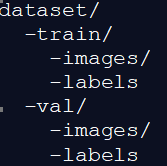<br>
Fuente: https://docs.ultralytics.com/datasets/

In [ ]:
annotations_path = os.path.join(car_parts_route, 'File1', 'ann')
images_path = os.path.join(car_parts_route, 'File1', 'img')
annotations_list = os.listdir(annotations_path)

crear_carpeta('dataset_car_parts')
crear_carpeta('dataset_car_parts/labels')

for json_name in annotations_list:
    ruta_imagen = os.path.join(images_path, json_name.replace('.json', ''))
    
    with open(os.path.join(annotations_path, json_name), 'r') as file:
        content = json.load(file)

    txt_content = ''

    for objects in content['objects']:
        classTitle = objects['classTitle'].lower()
        classTitle_num = inverted_car_parts_classes[classTitle]

        txt_content = txt_content + str(classTitle_num)
        
        polygon = objects['points']['exterior']
        for element in polygon:
            puntos = element
            puntos = normaliza_puntos(puntos, ruta_imagen)
            
            for number in puntos:
                txt_content = txt_content + ' ' + str(number)
        txt_content = txt_content + '\n'
        txt_content = txt_content + '\n'

    txt_name = 'dataset_car_parts/labels/' + json_name.lower().replace('.png', '').replace('.jpg', '').replace('.jpeg', '').replace('.json', '.txt').split('/')[-1].capitalize()
    crear_archivo(txt_name, txt_content)

La carpeta 'dataset_car_parts' ya existe.
La carpeta 'dataset_car_parts/labels' ya existe.
Contenido guardado en dataset_car_parts/labels/Car damages 100.txt
Contenido guardado en dataset_car_parts/labels/Car damages 101.txt
Contenido guardado en dataset_car_parts/labels/Car damages 102.txt
Contenido guardado en dataset_car_parts/labels/Car damages 103.txt
Contenido guardado en dataset_car_parts/labels/Car damages 1031.txt
Contenido guardado en dataset_car_parts/labels/Car damages 1032.txt
Contenido guardado en dataset_car_parts/labels/Car damages 1033.txt
Contenido guardado en dataset_car_parts/labels/Car damages 1034.txt
Contenido guardado en dataset_car_parts/labels/Car damages 1035.txt
Contenido guardado en dataset_car_parts/labels/Car damages 1036.txt
Contenido guardado en dataset_car_parts/labels/Car damages 1037.txt
Contenido guardado en dataset_car_parts/labels/Car damages 1038.txt
Contenido guardado en dataset_car_parts/labels/Car damages 1039.txt
Contenido guardado en dataset

### b) Transferencia de imagenes al directorio correspondiente:

A continuación, se guardan las imagenes del dataset a la carpeta 'dataset_car_parts/images'.

In [ ]:
crear_carpeta('dataset_car_parts/images')

In [ ]:
source_routes = [
    os.path.join(car_parts_route, 'File1', 'img')
]

destination_route = 'dataset_car_parts/images'

for source in source_routes:
    for filename in os.listdir(source):
        source_file = os.path.join(source, filename)
        if os.path.isfile(source_file):
            shutil.copy(source_file, destination_route)

print("Fotos copiadas exitosamente a la carpeta de destino.")

De momento, la estructura de carpetas es la siguiente:<br> 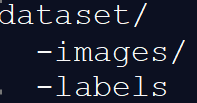

### c) División de imagenes en train y test:

En esta sección, las imágenes se dividen en un 80% para el conjunto de entrenamiento (train) y un 20% para el conjunto de prueba (test).

Primero, se "baraja" el listado de imagenes:

In [ ]:
car_parts_images_list = os.listdir('dataset_car_parts/images')
random.shuffle(car_parts_images_list)

Se calcula el número de imagenes de train:

In [ ]:
num_of_images = len(car_parts_images_list)
num_of_images_to_train = num_of_images * 0.8

Se crean las carpetas de train y de test dentro de las carpetas images y labels:

In [ ]:
crear_carpeta('dataset_car_parts/images/train')
crear_carpeta('dataset_car_parts/images/test')
crear_carpeta('dataset_car_parts/labels/train')
crear_carpeta('dataset_car_parts/labels/test')

Se mueven las imagenes de 'dataset_car_parts/images/' a 'dataset_car_parts/images/train' y 'dataset_car_parts/images/test'.

Se mueven los ficheros '.txt' de 'dataset_car_parts/labels/' a 'dataset_car_parts/labels/train' y 'dataset_car_parts/labels/test'.

In [40]:
for count, image_name in enumerate(car_parts_images_list):
    # Muevo las imagenes y labels a sus carpetas de train:
    if count < num_of_images_to_train:
        shutil.move('dataset_car_parts/images/' + image_name, 'dataset_car_parts/images/train/' + image_name)
        shutil.move('dataset_car_parts/labels/' + image_name.split('.')[0] + '.txt', 'dataset_car_parts/labels/train/' + image_name.split('.')[0] + '.txt')
    # Muevo las imagenes y labels a sus carpetas de test:
    else:
        shutil.move('dataset_car_parts/images/' + image_name, 'dataset_car_parts/images/test/' + image_name)
        shutil.move('dataset_car_parts/labels/' + image_name.split('.')[0] + '.txt', 'dataset_car_parts/labels/test/' + image_name.split('.')[0] + '.txt')

### d) Creacion del archivo 'config.yaml'

Se crea el siguiente archivo, que sirve para especificar al modelo las rutas donde están las imágenes, así como el valor asignado a cada una de las etiquetas.

En el siguiente enlace se detalla como tiene que estar informado el fichero 'config.yaml':<br>
https://docs.ultralytics.com/datasets/segment/#ultralytics-yolo-format

In [15]:
names_content = "\n".join([f"    {key}: {value}" for key, value in car_parts_classes.items()])

main_route = os.getcwd() + '/dataset_car_parts'

config_yaml_content = f"""
path: {main_route}
train: images/train
val: images/test

names:
{names_content}
"""

print(config_yaml_content)

crear_archivo('car_parts_config.yaml', config_yaml_content)


path: C:\Users\Usuario\Documents\MASTER/dataset_car_parts
train: images/train
val: images/test

names:
    0: quarter-panel
    1: front-wheel
    2: back-window
    3: trunk
    4: front-door
    5: rocker-panel
    6: grille
    7: windshield
    8: front-window
    9: back-door
    10: headlight
    11: back-wheel
    12: back-windshield
    13: hood
    14: fender
    15: tail-light
    16: license-plate
    17: front-bumper
    18: back-bumper
    19: mirror
    20: roof

Contenido guardado en car_parts_config.yaml


## Tuning:

Se realiza un ajuste de hiperparámetros (tuning) del modelo para intentar obtener los mejores parámetros posibles para su entrenamiento. Se llevan a cabo 70 iteraciones, con 20 épocas cada una. En el siguiente enlace se explica como se hace: https://docs.ultralytics.com/guides/hyperparameter-tuning/#usage-example

In [ ]:
model = YOLO("yolo11n-seg.yaml")  
model = YOLO("yolo11n-seg.pt") 
model = YOLO("yolo11n-seg.yaml").load("yolo11n-seg.pt")  

model.tune(data="car_parts_config.yaml", epochs=20, iterations=70, optimizer="AdamW", plots=False, save=False, val=False)

Transferred 561/561 items from pretrained weights
Tuner: Initialized Tuner instance with 'tune_dir=runs/segment/tune25'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/70 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Transferred 561/561 items from pretrained weights
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.yaml, data=car_parts_config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=False, save_period=-1, cache=False, device=None, workers=8, project=None, name=t

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)


2025/01/06 19:17:38 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 19:17:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 19:17:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(e28c0ea3a4894f9da4283a07ba852d57) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train272
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.34G      1.575       3.06      3.078      1.457        446        640: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.56G      1.481       2.45      1.894      1.377        457        640: 100%|██████████| 50/50 [00:16<00:00,  3.00it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20       4.5G      1.416      2.345      1.628      1.346        403        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.42G      1.368      2.267      1.488      1.312        454        640: 100%|██████████| 50/50 [00:17<00:00,  2.78it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.03G      1.294      2.122      1.339      1.272        387        640: 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.46G      1.235      2.012       1.25      1.237        334        640: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.36G      1.212      1.968        1.2      1.225        580        640: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.69G      1.177      1.899      1.148      1.207        401        640: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.65G      1.148      1.841        1.1      1.194        586        640: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.56G      1.121      1.792      1.037      1.177        283        640: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Closing dataloader mosaic


  0%|          | 0/50 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.54G       1.12      1.758      1.021      1.216        229        640: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.58G      1.094      1.704     0.9439      1.196        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.44G      1.071      1.644     0.9026      1.184        238        640: 100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.62G      1.045      1.577     0.8579      1.163        230        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G      1.027      1.543     0.8302      1.155        228        640: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.61G     0.9923      1.498      0.795      1.133        245        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20       3.6G     0.9729      1.477     0.7721      1.122        203        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.58G     0.9516      1.449     0.7527      1.108        231        640: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.53G      0.924      1.397     0.7282      1.098        235        640: 100%|██████████| 50/50 [00:13<00:00,  3.64it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.55G     0.9146      1.377     0.7094      1.085        237        640: 100%|██████████| 50/50 [00:13<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        199       3057       0.85      0.791      0.864      0.629      0.857      0.788      0.855      0.581

20 epochs completed in 0.094 hours.
Optimizer stripped from runs/segment/train272/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train272/weights/best.pt, 6.0MB

Validating runs/segment/train272/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


                   all        199       3057      0.851      0.791      0.864      0.629      0.855       0.79      0.855      0.581
         quarter-panel        160        162       0.73        0.6      0.775      0.471      0.822      0.657      0.794      0.467
           front-wheel        173        175      0.934      0.937      0.965       0.79      0.929      0.931      0.963      0.796
           back-window        156        231        0.9      0.856      0.914      0.642      0.899      0.848      0.899      0.597
                 trunk         66         77      0.674      0.597      0.652      0.494      0.725      0.636      0.678      0.457
            front-door        177        180      0.934       0.95      0.964      0.813      0.929      0.943       0.95      0.669
          rocker-panel        168        168      0.877      0.881      0.923      0.651      0.807       0.81      0.833      0.349
                grille        101        110      0.749      0.718   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.01028, momentum=0.92367) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00051), 100 bias(decay=0.0)


2025/01/06 19:23:41 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 19:23:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 19:23:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(358a1b4def414e22a0b9b566d2a3298a) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train273
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.57G      1.797      3.509      2.957      1.528        405        640: 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.4G      1.671       2.83      1.849       1.43        324        640: 100%|██████████| 50/50 [00:16<00:00,  3.08it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.33G      1.612      2.727      1.626      1.413        481        640: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.63G      1.491      2.479      1.414      1.333        433        640: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.52G      1.452      2.353      1.331       1.31        411        640: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20       4.3G      1.387       2.24      1.224      1.272        437        640: 100%|██████████| 50/50 [00:16<00:00,  3.03it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.67G      1.353      2.179      1.172      1.258        447        640: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.44G      1.305      2.082      1.102      1.226        403        640: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.44G      1.276      2.019      1.065      1.215        515        640: 100%|██████████| 50/50 [00:16<00:00,  3.08it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.53G      1.252      1.981      1.021      1.207        317        640: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.59G      1.234      1.875     0.9463      1.231        229        640: 100%|██████████| 50/50 [00:14<00:00,  3.34it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.56G      1.203      1.841      0.898      1.212        225        640: 100%|██████████| 50/50 [00:13<00:00,  3.66it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.44G      1.177      1.791     0.8653      1.199        238        640: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.62G      1.151      1.747     0.8297      1.184        230        640: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G      1.132      1.707     0.8026      1.169        228        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.62G      1.086      1.646     0.7614      1.146        245        640: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20       3.6G      1.075      1.618     0.7431      1.141        203        640: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.58G      1.053      1.589     0.7249      1.129        231        640: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.52G      1.021      1.538     0.6964      1.117        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.56G      1.002      1.506     0.6796      1.101        237        640: 100%|██████████| 50/50 [00:13<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


                   all        199       3057      0.839      0.792      0.863      0.626      0.841      0.789      0.851      0.579

20 epochs completed in 0.089 hours.
Optimizer stripped from runs/segment/train273/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train273/weights/best.pt, 6.0MB

Validating runs/segment/train273/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]


                   all        199       3057       0.84      0.791      0.864      0.626      0.841      0.789      0.852      0.579
         quarter-panel        160        162      0.773      0.586      0.756      0.473       0.81      0.606      0.769      0.443
           front-wheel        173        175      0.916      0.929      0.964      0.792      0.915      0.928      0.963      0.787
           back-window        156        231      0.893       0.87      0.928       0.66      0.886      0.861      0.907       0.62
                 trunk         66         77      0.628      0.519      0.655      0.481      0.662      0.545      0.674      0.454
            front-door        177        180       0.96      0.922      0.963      0.822      0.961      0.922      0.954      0.664
          rocker-panel        168        168       0.89      0.881       0.92      0.643      0.807      0.792      0.801      0.342
                grille        101        110      0.742      0.755   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00911, momentum=0.937) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)


2025/01/06 19:29:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 19:29:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 19:29:23 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(0807e527da6d4ad3851aafbd85cb5cd7) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train274
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.39G      1.542      3.101      3.115      1.319        443        640: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G      1.444      2.389      1.862      1.238        451        640: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.58G      1.412      2.292      1.609      1.233        403        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.41G      1.346      2.199      1.447      1.198        455        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.85G      1.287      2.095      1.309      1.158        383        640: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.34G      1.221      1.987      1.225      1.127        337        640: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.35G      1.203      1.943      1.177      1.118        567        640: 100%|██████████| 50/50 [00:16<00:00,  3.00it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.61G      1.158      1.864      1.114      1.101        394        640: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.59G      1.138      1.833      1.083      1.089        575        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.52G      1.118      1.797      1.027      1.075        287        640: 100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.56G        1.1        1.7     0.9816        1.1        229        640: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.57G      1.079      1.632     0.9058      1.082        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G      1.053      1.606     0.8726      1.071        239        640: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G      1.032      1.569     0.8309      1.059        231        640: 100%|██████████| 50/50 [00:13<00:00,  3.76it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G      1.011      1.523     0.8017      1.045        228        640: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.61G     0.9854      1.464     0.7725      1.033        245        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.66G     0.9662      1.446     0.7497      1.023        203        640: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.57G     0.9436      1.418     0.7313      1.012        231        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.55G     0.9223       1.39     0.7112      1.007        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G     0.9039      1.352     0.6911     0.9941        237        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


                   all        199       3057      0.868      0.789      0.871       0.64      0.871      0.791      0.862      0.592

20 epochs completed in 0.090 hours.
Optimizer stripped from runs/segment/train274/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train274/weights/best.pt, 6.0MB

Validating runs/segment/train274/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


                   all        199       3057      0.868      0.789      0.871      0.639      0.871      0.791      0.863      0.592
         quarter-panel        160        162      0.721       0.63      0.775      0.492      0.771      0.673      0.798      0.474
           front-wheel        173        175      0.895      0.937      0.962      0.787       0.89      0.931      0.954      0.786
           back-window        156        231      0.883      0.849      0.915      0.649      0.874       0.84      0.895      0.609
                 trunk         66         77      0.717      0.584      0.695      0.512      0.768      0.623      0.717      0.486
            front-door        177        180      0.962      0.928      0.957      0.815      0.962      0.928      0.954      0.677
          rocker-panel        168        168      0.896      0.869      0.923      0.644      0.819      0.792      0.838      0.358
                grille        101        110      0.789      0.718   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00911, momentum=0.93199) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00057), 100 bias(decay=0.0)


2025/01/06 19:35:11 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 19:35:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 19:35:11 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(cb930c33c2a64737bfcb0517e96f4087) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train275
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.35G      1.536      3.069      2.989      1.132        444        640: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.69G      1.448      2.383      1.788      1.065        450        640: 100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.58G       1.39      2.268      1.532      1.046        402        640: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.42G      1.345      2.221      1.396      1.022        454        640: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.85G      1.301      2.146      1.283     0.9943        382        640: 100%|██████████| 50/50 [00:16<00:00,  3.00it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.34G      1.226      1.982      1.186     0.9685        337        640: 100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.29G      1.192      1.909      1.119     0.9527        566        640: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.66G      1.159      1.862      1.068     0.9372        392        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.59G       1.14      1.824      1.038     0.9331        573        640: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.49G       1.11      1.786     0.9853     0.9166        287        640: 100%|██████████| 50/50 [00:16<00:00,  2.94it/s]


Closing dataloader mosaic


  0%|          | 0/50 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.56G        1.1      1.705     0.9673     0.9399        230        640: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.59G      1.076      1.629     0.8762     0.9278        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G      1.063      1.608     0.8489      0.922        239        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G      1.031      1.553     0.8043     0.9055        231        640: 100%|██████████| 50/50 [00:13<00:00,  3.70it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.59G     0.9996       1.51     0.7763     0.8932        228        640: 100%|██████████| 50/50 [00:13<00:00,  3.58it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.62G     0.9769      1.457     0.7495     0.8805        245        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.61G     0.9635      1.435     0.7273      0.874        203        640: 100%|██████████| 50/50 [00:12<00:00,  3.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.57G     0.9392      1.415     0.7042     0.8622        231        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.56G     0.9135       1.37      0.684      0.858        237        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G      0.902      1.334     0.6667     0.8476        237        640: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


                   all        199       3057      0.869      0.792       0.87      0.639      0.877       0.79      0.862      0.589

20 epochs completed in 0.091 hours.
Optimizer stripped from runs/segment/train275/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train275/weights/best.pt, 6.0MB

Validating runs/segment/train275/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


                   all        199       3057      0.869      0.792       0.87      0.638      0.877       0.79      0.862      0.589
         quarter-panel        160        162       0.78      0.605      0.761      0.479      0.841      0.636      0.794      0.472
           front-wheel        173        175      0.917      0.954      0.964      0.803      0.908      0.943      0.959      0.791
           back-window        156        231      0.856      0.848      0.911      0.644      0.858      0.844      0.892      0.606
                 trunk         66         77       0.73      0.571      0.679      0.523      0.759      0.571      0.712      0.479
            front-door        177        180      0.937      0.939      0.958      0.822      0.939      0.936      0.945      0.678
          rocker-panel        168        168      0.899      0.899      0.927      0.651      0.821      0.817      0.812       0.35
                grille        101        110      0.814      0.773   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00975, momentum=0.93041) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)


2025/01/06 19:40:58 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 19:40:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 19:40:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(de3924b539fa4ae78664336521d843cf) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train276
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.39G      1.373      2.671      3.047      1.357        446        640: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.71G      1.278      2.119      1.862       1.28        455        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.61G      1.236      2.052      1.611      1.257        405        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.51G      1.173      1.963      1.457      1.216        456        640: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.08G      1.121      1.823      1.314      1.177        384        640: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.34G      1.066      1.742      1.233      1.147        334        640: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.36G      1.056      1.693      1.171      1.139        573        640: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.69G      1.024      1.636      1.114      1.122        399        640: 100%|██████████| 50/50 [00:19<00:00,  2.54it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.65G     0.9943      1.605      1.075      1.105        580        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.49G     0.9776      1.558      1.029      1.095        282        640: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.56G     0.9487      1.494     0.9809      1.112        229        640: 100%|██████████| 50/50 [00:13<00:00,  3.76it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.57G     0.9365       1.44     0.9088      1.103        225        640: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G     0.9301       1.42     0.8814      1.098        239        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.62G     0.9088      1.368      0.841      1.084        230        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G     0.8881      1.345     0.8103      1.069        228        640: 100%|██████████| 50/50 [00:13<00:00,  3.74it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.63G     0.8575       1.29     0.7768      1.052        245        640: 100%|██████████| 50/50 [00:14<00:00,  3.46it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.64G     0.8451      1.266     0.7539      1.044        203        640: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.57G     0.8255      1.242      0.734      1.034        231        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.54G      0.804      1.207     0.7084      1.023        235        640: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.56G     0.7869      1.184     0.6908       1.01        237        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


                   all        199       3057      0.859      0.798      0.871      0.639      0.872      0.796      0.864      0.593

20 epochs completed in 0.091 hours.
Optimizer stripped from runs/segment/train276/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train276/weights/best.pt, 6.0MB

Validating runs/segment/train276/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]


                   all        199       3057      0.859      0.798      0.871      0.639      0.872      0.797      0.864      0.592
         quarter-panel        160        162      0.803       0.63      0.799       0.49      0.849      0.626       0.79      0.472
           front-wheel        173        175      0.937      0.935      0.966      0.787      0.934      0.926      0.961      0.798
           back-window        156        231      0.887      0.866      0.928      0.641        0.9      0.853      0.902      0.597
                 trunk         66         77      0.732       0.61      0.688      0.514      0.741      0.595      0.706      0.472
            front-door        177        180      0.949      0.944      0.962      0.828      0.951      0.939      0.956       0.68
          rocker-panel        168        168      0.902      0.881      0.921      0.647      0.879      0.833      0.863       0.38
                grille        101        110       0.74      0.726   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00911, momentum=0.94091) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00061), 100 bias(decay=0.0)


2025/01/06 19:46:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 19:46:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 19:46:47 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(59dfcc11593741779b2d93d8df2b0300) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train277
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.38G      1.502      2.943      3.089      1.412        443        640: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.71G      1.421      2.343      1.869       1.34        451        640: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.62G      1.347      2.234      1.587      1.302        403        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.44G      1.312       2.19      1.459      1.278        455        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.84G      1.249      2.031      1.316      1.238        383        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.36G      1.204      1.941      1.225      1.218        337        640: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.35G      1.175      1.898      1.164      1.198        567        640: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.61G      1.142      1.839      1.101      1.185        394        640: 100%|██████████| 50/50 [00:17<00:00,  2.78it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.59G      1.113      1.793      1.078       1.17        575        640: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.53G      1.084      1.732      1.017      1.152        287        640: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.57G      1.079      1.684     0.9819      1.187        229        640: 100%|██████████| 50/50 [00:13<00:00,  3.64it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.57G      1.046      1.617     0.9018      1.163        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.44G      1.038      1.573     0.8792      1.156        239        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G      1.013       1.53     0.8428      1.142        231        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.59G     0.9873       1.48     0.8054      1.127        228        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.61G     0.9623      1.441     0.7766      1.113        245        640: 100%|██████████| 50/50 [00:13<00:00,  3.73it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.64G     0.9439      1.415     0.7597        1.1        203        640: 100%|██████████| 50/50 [00:14<00:00,  3.35it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.57G     0.9191      1.381     0.7353      1.087        231        640: 100%|██████████| 50/50 [00:12<00:00,  3.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.56G      0.909      1.357     0.7176      1.086        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G     0.8891      1.318     0.6974       1.07        237        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


                   all        199       3057      0.847      0.805       0.87      0.635      0.849      0.804      0.862      0.591

20 epochs completed in 0.092 hours.
Optimizer stripped from runs/segment/train277/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train277/weights/best.pt, 6.0MB

Validating runs/segment/train277/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


                   all        199       3057      0.846      0.805       0.87      0.635      0.849      0.804      0.862      0.591
         quarter-panel        160        162      0.731      0.617       0.78      0.493      0.792       0.66      0.771      0.467
           front-wheel        173        175      0.919      0.943      0.964       0.79      0.919      0.943      0.956      0.793
           back-window        156        231       0.85      0.853      0.929      0.652      0.853      0.853      0.908      0.619
                 trunk         66         77      0.654      0.636      0.673      0.494      0.669      0.649      0.707      0.454
            front-door        177        180      0.952      0.939      0.963      0.824      0.947      0.933      0.944      0.678
          rocker-panel        168        168      0.877      0.887      0.926      0.651      0.802       0.81      0.827      0.349
                grille        101        110      0.738      0.764   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00815, momentum=0.93911) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00065), 100 bias(decay=0.0)


2025/01/06 19:52:38 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 19:52:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 19:52:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(464141773d0b47f096c8baee246b0e42) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train278
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.33G      1.218      2.374      3.424      1.659        443        640: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.7G      1.143      1.873      2.015      1.561        451        640: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.57G      1.101      1.836      1.728      1.541        403        640: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.43G      1.064      1.783      1.572      1.509        455        640: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.85G       1.02      1.666      1.415      1.464        383        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.35G     0.9795      1.599      1.315      1.439        337        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.34G     0.9689      1.568      1.259      1.423        567        640: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.61G     0.9401      1.525      1.213      1.407        394        640: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.59G      0.904      1.461      1.153       1.38        575        640: 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.49G     0.8843      1.421      1.101      1.362        287        640: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.56G     0.8867      1.399      1.086       1.41        229        640: 100%|██████████| 50/50 [00:13<00:00,  3.65it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.57G     0.8659       1.34     0.9886      1.384        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G     0.8477      1.294     0.9554      1.368        239        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.8309      1.263     0.9158      1.357        231        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.59G     0.8022      1.222     0.8779      1.332        228        640: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.62G     0.7806      1.181     0.8453      1.312        245        640: 100%|██████████| 50/50 [00:12<00:00,  3.89it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.66G     0.7687      1.168     0.8245      1.301        203        640: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.57G     0.7554      1.143     0.8034       1.29        231        640: 100%|██████████| 50/50 [00:14<00:00,  3.45it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.55G      0.734      1.105     0.7785      1.279        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G     0.7214      1.089     0.7559      1.263        237        640: 100%|██████████| 50/50 [00:12<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


                   all        199       3057      0.867      0.796      0.873      0.639       0.87      0.798       0.87      0.593

20 epochs completed in 0.092 hours.
Optimizer stripped from runs/segment/train278/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train278/weights/best.pt, 6.0MB

Validating runs/segment/train278/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


                   all        199       3057      0.867      0.797      0.873      0.638      0.872      0.797      0.869      0.594
         quarter-panel        160        162      0.747      0.639      0.775      0.497      0.798      0.657      0.778      0.479
           front-wheel        173        175      0.919      0.966      0.956      0.781      0.909      0.954      0.953      0.783
           back-window        156        231      0.908      0.848      0.925      0.645      0.901       0.84      0.902       0.61
                 trunk         66         77      0.682       0.61      0.663      0.493      0.729      0.649      0.714      0.471
            front-door        177        180      0.949      0.939      0.967      0.828      0.945      0.933      0.962      0.674
          rocker-panel        168        168      0.868       0.86      0.922      0.635      0.831      0.822      0.866      0.369
                grille        101        110      0.722      0.755   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00911, momentum=0.93154) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00066), 100 bias(decay=0.0)


2025/01/06 19:58:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 19:58:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 19:58:32 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(7f18be63f51140958d581324cc2579dd) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train279
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.36G      1.532      3.017      3.087      1.164        442        640: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.32G      1.445      2.377      1.876      1.091        442        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.54G      1.391      2.312      1.617      1.073        392        640: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.49G      1.334      2.177      1.465      1.042        448        640: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.72G      1.263      2.073      1.321      1.003        381        640: 100%|██████████| 50/50 [00:16<00:00,  2.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20       4.5G      1.214      1.967      1.237     0.9845        336        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20       4.5G      1.172      1.908      1.166      0.964        549        640: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.61G      1.133      1.837      1.111     0.9498        398        640: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.54G      1.113      1.789      1.074     0.9412        557        640: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.48G      1.092      1.745      1.019     0.9339        290        640: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.54G      1.076      1.664     0.9854     0.9511        229        640: 100%|██████████| 50/50 [00:14<00:00,  3.49it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.56G      1.055      1.606     0.9083     0.9386        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.87it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G       1.04      1.576     0.8793     0.9323        239        640: 100%|██████████| 50/50 [00:12<00:00,  3.89it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G      1.029       1.54     0.8359     0.9279        228        640: 100%|██████████| 50/50 [00:12<00:00,  3.87it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.55G     0.9959      1.497     0.8054     0.9105        228        640: 100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20       3.6G     0.9608      1.451     0.7692     0.8951        245        640: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20       3.6G     0.9371      1.405     0.7452     0.8855        204        640: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.58G     0.9186      1.386     0.7306     0.8756        231        640: 100%|██████████| 50/50 [00:13<00:00,  3.61it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.53G     0.9015      1.339     0.7108     0.8707        236        640: 100%|██████████| 50/50 [00:14<00:00,  3.53it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.54G     0.8793      1.317     0.6881     0.8597        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        199       3057      0.866      0.805      0.869      0.634      0.877      0.794      0.858      0.584

20 epochs completed in 0.093 hours.
Optimizer stripped from runs/segment/train279/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train279/weights/best.pt, 6.0MB

Validating runs/segment/train279/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]


                   all        199       3057       0.87      0.803      0.869      0.634      0.877      0.794      0.858      0.584
         quarter-panel        160        162      0.734      0.648      0.766      0.487      0.769      0.636      0.768      0.458
           front-wheel        173        175      0.914       0.96      0.965      0.791      0.914      0.954      0.964      0.786
           back-window        156        231      0.897      0.879      0.917      0.656      0.897      0.866      0.897       0.62
                 trunk         66         77      0.637      0.524      0.652      0.505      0.757      0.584      0.696      0.475
            front-door        177        180      0.949      0.937      0.962      0.815      0.949      0.935      0.957      0.675
          rocker-panel        168        168      0.918      0.899      0.933      0.652      0.821       0.79      0.788      0.343
                grille        101        110      0.805      0.745   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00807, momentum=0.93911) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00064), 100 bias(decay=0.0)


2025/01/06 20:04:28 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 20:04:29 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:04:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(b07537a80564428cb1d774e4dc183a1a) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train280
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.39G      1.175      2.294      3.551      1.622        446        640: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.71G      1.109      1.817      2.098      1.536        457        640: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.47G      1.073      1.768      1.807      1.522        407        640: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.42G      1.039      1.722      1.637      1.491        455        640: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.01G     0.9897      1.616      1.469      1.445        386        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20       4.4G     0.9413      1.548      1.356      1.408        338        640: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.35G     0.9247      1.504      1.294      1.392        581        640: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.71G     0.8991      1.454      1.245      1.377        399        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.63G     0.8808      1.425      1.211      1.362        591        640: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.52G     0.8544      1.387      1.162      1.341        283        640: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.57G     0.8519       1.35      1.123      1.379        229        640: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.57G     0.8324      1.291       1.03      1.356        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.44G     0.8148      1.262     0.9982      1.344        238        640: 100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.8022      1.233      0.955      1.331        230        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G     0.7774      1.183     0.9157      1.307        227        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.61G     0.7631      1.149     0.8897      1.298        245        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20       3.6G     0.7467      1.136     0.8656      1.288        203        640: 100%|██████████| 50/50 [00:12<00:00,  3.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.59G     0.7327      1.109     0.8375      1.272        231        640: 100%|██████████| 50/50 [00:13<00:00,  3.82it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.53G     0.7111      1.081     0.8083      1.257        236        640: 100%|██████████| 50/50 [00:13<00:00,  3.59it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.56G     0.7002      1.059     0.7939      1.241        237        640: 100%|██████████| 50/50 [00:13<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


                   all        199       3057      0.856      0.811      0.879      0.642      0.864       0.81      0.872      0.597

20 epochs completed in 0.093 hours.
Optimizer stripped from runs/segment/train280/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train280/weights/best.pt, 6.0MB

Validating runs/segment/train280/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]


                   all        199       3057      0.857       0.81      0.879      0.642      0.866      0.809      0.872      0.597
         quarter-panel        160        162      0.764       0.64      0.787      0.502      0.814       0.65      0.788      0.478
           front-wheel        173        175      0.943      0.944       0.97      0.797      0.943      0.943      0.962      0.803
           back-window        156        231      0.867      0.866      0.923      0.654      0.868      0.854      0.902      0.621
                 trunk         66         77      0.641      0.571      0.692      0.511      0.697       0.61      0.724      0.474
            front-door        177        180      0.964       0.95      0.967      0.829       0.96      0.944      0.957      0.685
          rocker-panel        168        168      0.882      0.905      0.934      0.641      0.816      0.821       0.84      0.365
                grille        101        110      0.704      0.809   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00804, momentum=0.94545) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00067), 100 bias(decay=0.0)


2025/01/06 20:10:23 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 20:10:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:10:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(85a8c294c0bd42dabc3cf026690d9e5d) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train281
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.34G      1.245      2.449      3.422       1.72        428        640: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.49G      1.169      1.923      2.047       1.62        420        640: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.72G      1.131      1.866      1.755      1.601        373        640: 100%|██████████| 50/50 [00:16<00:00,  2.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.14G      1.097      1.829      1.571      1.569        398        640: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.69G      1.037       1.71       1.44       1.52        377        640: 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.36G      1.012      1.647      1.355      1.499        432        640: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.56G     0.9751      1.596      1.267      1.464        362        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.42G     0.9589      1.558      1.216      1.454        483        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.34G     0.9243      1.493      1.155      1.428        502        640: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.49G     0.9121      1.469       1.13      1.414        483        640: 100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.55G     0.8973      1.409      1.035      1.439        231        640: 100%|██████████| 50/50 [00:14<00:00,  3.56it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.58G     0.8814      1.362     0.9718      1.421        225        640: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G     0.8612      1.325     0.9453      1.406        240        640: 100%|██████████| 50/50 [00:12<00:00,  4.08it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.8488      1.281     0.9022      1.393        232        640: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G     0.8177      1.246     0.8651      1.371        229        640: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.61G     0.7967      1.199     0.8309      1.353        245        640: 100%|██████████| 50/50 [00:12<00:00,  4.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.64G     0.7872       1.18     0.8124      1.346        205        640: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.57G     0.7736      1.166     0.7991      1.335        233        640: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.57G     0.7506      1.135     0.7717      1.324        239        640: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.56G     0.7384      1.105     0.7473      1.306        237        640: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


                   all        199       3057      0.834      0.827      0.882      0.643      0.861      0.805      0.873      0.596

20 epochs completed in 0.090 hours.
Optimizer stripped from runs/segment/train281/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train281/weights/best.pt, 6.0MB

Validating runs/segment/train281/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


                   all        199       3057      0.835      0.827      0.883      0.644       0.86      0.805      0.873      0.596
         quarter-panel        160        162      0.771      0.722      0.816      0.519      0.852      0.639      0.804       0.49
           front-wheel        173        175       0.86      0.954      0.962      0.792      0.878      0.943      0.962      0.802
           back-window        156        231      0.883      0.879      0.928      0.658       0.89      0.857      0.908      0.626
                 trunk         66         77      0.606      0.619      0.695      0.497      0.688      0.629      0.721      0.486
            front-door        177        180      0.909      0.941      0.967      0.826      0.918      0.928      0.953      0.686
          rocker-panel        168        168      0.889      0.911      0.944      0.647       0.84      0.815      0.819      0.356
                grille        101        110      0.747        0.8   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00865, momentum=0.95917) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0007), 100 bias(decay=0.0)


2025/01/06 20:16:08 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 20:16:08 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:16:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(87bef5b526ac49a18ca6e8c21b3eb95c) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train282
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.69G      1.253      2.475      3.626      1.895        385        640: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.79G      1.202      2.005      2.271      1.814        380        640: 100%|██████████| 50/50 [00:16<00:00,  2.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.46G      1.154      1.928      1.903      1.779        477        640: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.46G      1.103      1.839        1.7      1.732        364        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.65G      1.072       1.75      1.566      1.697        436        640: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.82G      1.015      1.671      1.447      1.651        438        640: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.44G     0.9915      1.615      1.365      1.635        450        640: 100%|██████████| 50/50 [00:16<00:00,  2.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.44G     0.9624      1.551      1.294      1.601        489        640: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.72G     0.9421       1.52       1.26      1.585        443        640: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.35G     0.9305      1.508      1.205      1.564        440        640: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.55G     0.8969      1.443      1.142      1.601        228        640: 100%|██████████| 50/50 [00:14<00:00,  3.55it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.56G     0.8897      1.389       1.07      1.583        222        640: 100%|██████████| 50/50 [00:13<00:00,  3.68it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G     0.8693      1.348      1.029      1.565        238        640: 100%|██████████| 50/50 [00:14<00:00,  3.41it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.8665       1.32     0.9929      1.564        229        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G     0.8346      1.284     0.9539      1.535        226        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20       3.6G      0.824      1.244     0.9222      1.524        245        640: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.64G     0.8012      1.229     0.9035      1.505        203        640: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.56G      0.787      1.212     0.8759      1.491        230        640: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.53G     0.7679      1.176     0.8557       1.48        233        640: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.55G     0.7625      1.155       0.84      1.464        237        640: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


                   all        199       3057      0.847      0.804      0.873      0.632      0.844      0.803      0.858      0.585

20 epochs completed in 0.090 hours.
Optimizer stripped from runs/segment/train282/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train282/weights/best.pt, 6.0MB

Validating runs/segment/train282/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


                   all        199       3057      0.847      0.804      0.872      0.632      0.843      0.803      0.858      0.585
         quarter-panel        160        162      0.808      0.546      0.772       0.48      0.831      0.568      0.769      0.467
           front-wheel        173        175       0.88      0.949      0.958      0.782      0.895      0.966      0.962      0.793
           back-window        156        231      0.878      0.873       0.92      0.636      0.861      0.858        0.9      0.596
                 trunk         66         77      0.665      0.532       0.66      0.483       0.71      0.571       0.68       0.46
            front-door        177        180      0.941      0.944      0.964      0.819      0.938      0.944      0.954      0.674
          rocker-panel        168        168      0.875      0.911      0.933      0.639      0.795      0.833      0.794      0.343
                grille        101        110      0.714      0.773   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00822, momentum=0.98) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00081), 100 bias(decay=0.0)


2025/01/06 20:21:54 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:21:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 20:21:54 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(2bcf4640cc6e4a9bba100ec5face01cc) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train283
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.54G     0.8525      1.747      3.529      1.648        435        640: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.55G     0.8226      1.392      2.187      1.571        444        640: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.55G     0.8142      1.344      1.884      1.577        407        640: 100%|██████████| 50/50 [00:16<00:00,  3.08it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.35G     0.7785      1.313      1.729      1.532        448        640: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.92G      0.741       1.23      1.566      1.485        377        640: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.51G     0.7132      1.187      1.463      1.457        340        640: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.28G      0.697      1.154      1.388      1.442        545        640: 100%|██████████| 50/50 [00:18<00:00,  2.76it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.66G     0.6886      1.119      1.335      1.427        392        640: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.39G     0.6687      1.088      1.296      1.406        559        640: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.48G     0.6519      1.063      1.236      1.387        287        640: 100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


Closing dataloader mosaic


  0%|          | 0/50 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.56G     0.6435      1.015      1.177      1.421        231        640: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.57G     0.6199      0.983      1.092      1.391        225        640: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G     0.6148     0.9614      1.043      1.379        240        640: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.6083     0.9478          1      1.368        232        640: 100%|██████████| 50/50 [00:13<00:00,  3.77it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G     0.5884     0.9196     0.9625      1.348        229        640: 100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.62G     0.5749     0.8923     0.9217      1.329        245        640: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.66G     0.5704     0.8782     0.9065       1.33        206        640: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.57G     0.5591     0.8636     0.8863      1.318        233        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.58G     0.5481     0.8451     0.8653      1.307        240        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.56G     0.5396     0.8284     0.8464      1.293        237        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


                   all        199       3057      0.836      0.786      0.855      0.613      0.846      0.783      0.847      0.563

20 epochs completed in 0.089 hours.
Optimizer stripped from runs/segment/train283/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train283/weights/best.pt, 6.0MB

Validating runs/segment/train283/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


                   all        199       3057      0.836      0.786      0.855      0.613      0.846      0.783      0.847      0.564
         quarter-panel        160        162      0.649      0.593      0.713      0.444      0.743      0.642      0.745      0.417
           front-wheel        173        175      0.914      0.914      0.953      0.748      0.909      0.903      0.944      0.757
           back-window        156        231      0.833      0.861      0.915      0.638      0.828      0.852      0.896      0.588
                 trunk         66         77       0.68      0.558      0.649      0.472      0.738      0.584      0.671       0.44
            front-door        177        180      0.947      0.944      0.964       0.81      0.942      0.939      0.951      0.656
          rocker-panel        168        168      0.876      0.881      0.939      0.629      0.784      0.786      0.802      0.321
                grille        101        110      0.681      0.755   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00807, momentum=0.93911) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00039), 100 bias(decay=0.0)


2025/01/06 20:27:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:27:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 20:27:33 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(52a3da76a4d54859aa1987282e26e4da) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train284
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.4G      1.228      2.364      2.444      1.658        480        640: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.72G      1.147      1.924      1.474      1.561        472        640: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.49G      1.107      1.834      1.259      1.538        400        640: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.64G      1.063      1.791      1.145      1.499        469        640: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.96G      1.026      1.687      1.034      1.454        412        640: 100%|██████████| 50/50 [00:17<00:00,  2.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.44G      0.983      1.603     0.9676      1.429        324        640: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.73G     0.9606      1.572     0.9299      1.417        632        640: 100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.68G     0.9383      1.519      0.885      1.391        412        640: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.38G      0.915      1.477     0.8518      1.376        632        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.54G     0.8993      1.443     0.8133      1.359        292        640: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.53G     0.8679      1.396     0.7923      1.404        226        640: 100%|██████████| 50/50 [00:13<00:00,  3.59it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.55G     0.8676      1.368     0.7361       1.39        219        640: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20       3.4G     0.8459      1.313     0.7122       1.38        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.56G     0.8368      1.277     0.6747      1.362        222        640: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.56G      0.811      1.253     0.6571      1.346        217        640: 100%|██████████| 50/50 [00:13<00:00,  3.72it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.58G     0.7886      1.215     0.6322       1.32        242        640: 100%|██████████| 50/50 [00:14<00:00,  3.48it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.57G      0.767      1.191     0.6097      1.313        200        640: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.54G     0.7593      1.172      0.594      1.299        223        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.52G      0.744      1.138     0.5764      1.295        226        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.52G     0.7325      1.119     0.5645      1.275        233        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


                   all        199       3057      0.843      0.801      0.864      0.631      0.853      0.784      0.854      0.579

20 epochs completed in 0.092 hours.
Optimizer stripped from runs/segment/train284/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train284/weights/best.pt, 6.0MB

Validating runs/segment/train284/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


                   all        199       3057      0.841      0.802      0.865      0.631      0.853      0.784      0.855      0.579
         quarter-panel        160        162      0.687      0.757      0.789      0.493       0.73        0.7      0.782      0.458
           front-wheel        173        175      0.954      0.942      0.968      0.784      0.953      0.936      0.966      0.795
           back-window        156        231      0.862      0.874      0.924      0.639       0.87      0.866      0.902      0.595
                 trunk         66         77      0.672      0.571       0.65      0.498      0.742      0.584      0.703      0.444
            front-door        177        180      0.944      0.928      0.966      0.823       0.96      0.928      0.959      0.682
          rocker-panel        168        168      0.886      0.905      0.938      0.649      0.837      0.827      0.855      0.353
                grille        101        110      0.674      0.764   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00698, momentum=0.9537) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00073), 100 bias(decay=0.0)


2025/01/06 20:33:26 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:33:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 20:33:26 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(5010d4654637435db1a1193bc38da4d0) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train285
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.41G      1.147      2.279      3.941      1.709        456        640: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.14G      1.097      1.804      2.386      1.622        508        640: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20       4.4G      1.032      1.703      1.987      1.579        456        640: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.23G     0.9946      1.629       1.77      1.547        395        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.42G     0.9797      1.605      1.677      1.532        297        640: 100%|██████████| 50/50 [00:16<00:00,  3.03it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.15G     0.9462      1.537      1.577      1.498        413        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.89G     0.9074      1.449      1.441       1.46        445        640: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.81G     0.8698      1.399      1.362      1.433        404        640: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.36G      0.848      1.365      1.313      1.422        326        640: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.81G      0.834      1.345       1.26      1.403        442        640: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.56G     0.8124      1.269      1.157       1.42        230        640: 100%|██████████| 50/50 [00:13<00:00,  3.66it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.59G     0.8005      1.242      1.097      1.403        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.46G      0.787      1.208      1.056      1.394        240        640: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.64G      0.784      1.178      1.035      1.383        234        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G      0.755      1.151     0.9898      1.366        230        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.61G     0.7442       1.12     0.9599      1.352        247        640: 100%|██████████| 50/50 [00:13<00:00,  3.77it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.65G     0.7222      1.092     0.9223      1.338        207        640: 100%|██████████| 50/50 [00:14<00:00,  3.51it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.57G     0.7123      1.074     0.9083      1.328        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.56G      0.695      1.052     0.8833      1.315        243        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.58G     0.6791      1.032      0.859      1.298        238        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


                   all        199       3057      0.844      0.821      0.876      0.645      0.866      0.805      0.867      0.594

20 epochs completed in 0.091 hours.
Optimizer stripped from runs/segment/train285/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train285/weights/best.pt, 6.0MB

Validating runs/segment/train285/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


                   all        199       3057      0.853      0.812      0.876      0.645      0.866      0.804      0.867      0.594
         quarter-panel        160        162      0.738      0.704      0.792      0.496      0.801      0.722      0.797      0.481
           front-wheel        173        175      0.924      0.931      0.954      0.785      0.928      0.931      0.952      0.787
           back-window        156        231       0.83      0.891      0.928      0.652      0.842      0.883      0.913      0.612
                 trunk         66         77      0.666      0.569      0.677      0.528      0.727      0.587      0.687      0.472
            front-door        177        180       0.95       0.95      0.968      0.828      0.958       0.95      0.958      0.684
          rocker-panel        168        168      0.863      0.899      0.931      0.654      0.826      0.839      0.846      0.386
                grille        101        110      0.791      0.791   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00692, momentum=0.95317) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00072), 100 bias(decay=0.0)


2025/01/06 20:39:14 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:39:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 20:39:14 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(a24584481efa4f6591f4eafae827e6f8) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train286
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.49G      1.206      2.387      4.195      1.752        435        640: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.54G      1.122      1.863      2.481       1.64        447        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.45G      1.089      1.798      2.121      1.623        405        640: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.48G      1.046       1.73      1.904      1.579        443        640: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.94G      1.011      1.653      1.745      1.544        370        640: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.31G     0.9638      1.591       1.61      1.512        340        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.28G     0.9381      1.529      1.519      1.486        526        640: 100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.62G     0.9097      1.487      1.443      1.463        389        640: 100%|██████████| 50/50 [00:16<00:00,  3.03it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.47G      0.895      1.463      1.406       1.46        560        640: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.44G     0.8783      1.421      1.347      1.442        291        640: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.56G     0.8735      1.372       1.29      1.473        230        640: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.59G     0.8414      1.312      1.185      1.435        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.46G     0.8367      1.281      1.138      1.436        240        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.8226       1.25      1.099      1.414        234        640: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.59G     0.7884      1.207       1.05      1.395        230        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.63G     0.7711      1.178      1.016      1.377        248        640: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.65G     0.7593       1.15     0.9862      1.372        207        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.57G     0.7483      1.132     0.9686      1.356        236        640: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.56G     0.7287        1.1     0.9375      1.344        242        640: 100%|██████████| 50/50 [00:13<00:00,  3.60it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G     0.7118      1.076     0.9162      1.327        238        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


                   all        199       3057       0.87      0.804      0.877      0.641      0.875      0.802      0.869      0.596

20 epochs completed in 0.091 hours.
Optimizer stripped from runs/segment/train286/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train286/weights/best.pt, 6.0MB

Validating runs/segment/train286/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


                   all        199       3057       0.87      0.804      0.877      0.641      0.874      0.803       0.87      0.596
         quarter-panel        160        162      0.792      0.642      0.777      0.488      0.829      0.659      0.792      0.486
           front-wheel        173        175      0.939       0.92      0.961      0.796      0.945      0.926      0.961      0.793
           back-window        156        231      0.896      0.857      0.932      0.656      0.891      0.852      0.906      0.621
                 trunk         66         77      0.662       0.61      0.675      0.496      0.693      0.636      0.702      0.477
            front-door        177        180       0.94      0.939      0.966      0.826       0.94      0.939      0.955      0.681
          rocker-panel        168        168      0.892      0.893      0.947       0.66      0.821      0.821       0.84      0.385
                grille        101        110      0.734      0.745   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00669, momentum=0.94247) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00073), 100 bias(decay=0.0)


2025/01/06 20:45:03 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:45:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 20:45:03 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(d17a93df2ffc4567b3e78b7c9ede87af) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train287
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.56G      1.517      2.954      4.364      2.464        457        640: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.56G      1.425      2.367      2.642      2.327        321        640: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.72G      1.377      2.246      2.228      2.283        457        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.28G       1.33       2.21      2.035      2.233        384        640: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.65G      1.267      2.053      1.846      2.166        416        640: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.28G      1.245      2.029      1.725      2.148        471        640: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.39G      1.186      1.956      1.619      2.094        428        640: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.53G      1.141      1.859       1.53       2.05        358        640: 100%|██████████| 50/50 [00:16<00:00,  3.04it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.31G      1.103      1.808      1.464      2.027        451        640: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.42G      1.111      1.807      1.426       2.02        426        640: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.54G       1.08      1.698      1.321      2.043        230        640: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.59G      1.065      1.661      1.237      2.025        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.46G      1.046      1.612      1.182      2.006        240        640: 100%|██████████| 50/50 [00:12<00:00,  3.87it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G      1.035      1.565      1.139      1.984        234        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G     0.9982      1.525      1.101      1.958        230        640: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.65G     0.9774      1.473      1.063      1.941        248        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.64G     0.9596      1.457      1.044      1.923        207        640: 100%|██████████| 50/50 [00:12<00:00,  3.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.59G      0.937      1.427      1.008      1.899        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.54G     0.9186      1.389     0.9805      1.887        242        640: 100%|██████████| 50/50 [00:13<00:00,  3.74it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G     0.8994      1.362     0.9555      1.861        238        640: 100%|██████████| 50/50 [00:14<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


                   all        199       3057      0.846      0.816      0.876      0.646      0.856      0.813      0.873      0.596

20 epochs completed in 0.091 hours.
Optimizer stripped from runs/segment/train287/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train287/weights/best.pt, 6.0MB

Validating runs/segment/train287/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


                   all        199       3057      0.846      0.817      0.876      0.646      0.857      0.813      0.873      0.596
         quarter-panel        160        162       0.72      0.714      0.797      0.498      0.752      0.698      0.803      0.484
           front-wheel        173        175      0.948      0.939      0.969       0.79       0.96      0.943      0.969      0.793
           back-window        156        231      0.905      0.863      0.927      0.654      0.904      0.852      0.911      0.626
                 trunk         66         77       0.63      0.649      0.674      0.515      0.646      0.641      0.713       0.48
            front-door        177        180      0.945      0.933      0.969      0.821      0.946      0.933       0.96      0.678
          rocker-panel        168        168      0.828      0.911      0.926       0.66      0.784      0.857      0.846      0.356
                grille        101        110       0.74        0.8   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00669, momentum=0.94799) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00058), 100 bias(decay=0.0)


2025/01/06 20:50:49 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 20:50:49 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:50:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(e7787494c9df457b91b882a0dc995ada) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train288
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.5G      1.315      2.674      3.875      2.468        435        640: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.54G      1.231      2.057      2.298      2.312        447        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.46G      1.208      1.994      1.959      2.299        405        640: 100%|██████████| 50/50 [00:17<00:00,  2.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.49G      1.142      1.915      1.761       2.21        443        640: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.88G      1.096      1.803      1.592      2.161        370        640: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.33G      1.044      1.729      1.484      2.115        340        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20       4.3G      1.024      1.688      1.397      2.088        526        640: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.57G      0.994       1.64      1.334      2.067        389        640: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.42G     0.9765      1.599      1.291      2.044        560        640: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.42G      0.958      1.561       1.24      2.024        291        640: 100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.56G     0.9389      1.483      1.183      2.049        230        640: 100%|██████████| 50/50 [00:14<00:00,  3.54it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.59G     0.9145      1.431      1.071      2.013        225        640: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.46G     0.9137      1.406      1.043      2.014        240        640: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.9057      1.377      1.011      2.004        234        640: 100%|██████████| 50/50 [00:12<00:00,  3.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G     0.8609      1.321     0.9582      1.961        230        640: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.63G     0.8394      1.286     0.9229      1.936        248        640: 100%|██████████| 50/50 [00:12<00:00,  3.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.65G     0.8328      1.271     0.9063      1.933        207        640: 100%|██████████| 50/50 [00:12<00:00,  3.89it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.59G     0.8149       1.24     0.8776      1.911        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.87it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.58G     0.7927      1.212      0.856      1.888        242        640: 100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G     0.7795      1.183     0.8308      1.866        238        640: 100%|██████████| 50/50 [00:13<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


                   all        199       3057      0.874      0.802      0.881      0.642      0.888      0.795      0.873      0.593

20 epochs completed in 0.091 hours.
Optimizer stripped from runs/segment/train288/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train288/weights/best.pt, 6.0MB

Validating runs/segment/train288/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]


                   all        199       3057      0.873      0.803      0.881      0.642      0.888      0.795      0.873      0.593
         quarter-panel        160        162      0.815      0.598      0.802      0.504      0.901      0.611      0.807      0.481
           front-wheel        173        175      0.922      0.943       0.96      0.793      0.944      0.949      0.964      0.799
           back-window        156        231      0.899      0.853      0.928      0.645      0.906       0.83      0.908      0.615
                 trunk         66         77       0.68      0.558      0.681      0.519      0.754      0.559      0.695      0.475
            front-door        177        180       0.96      0.933      0.969      0.819      0.969      0.933      0.958      0.687
          rocker-panel        168        168      0.886      0.899      0.934      0.641      0.865      0.838      0.857      0.359
                grille        101        110      0.767      0.773   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00804, momentum=0.94545) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00067), 100 bias(decay=0.0)


2025/01/06 20:56:38 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 20:56:38 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 20:56:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(e74a728e58d245829eb90394af34b09c) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train289
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.54G      1.317      2.521      3.068      1.354        474        640: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.71G      1.243      2.042      1.872      1.287        420        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.13G      1.199      1.979      1.596      1.263        526        640: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20       4.8G      1.155      1.896      1.437      1.236        511        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.49G      1.101      1.772      1.307      1.205        392        640: 100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.67G      1.065      1.717        1.2      1.175        465        640: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20       4.7G      1.045      1.685       1.18      1.162        402        640: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.57G     0.9964      1.599      1.096      1.132        524        640: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.28G     0.9764      1.547      1.044      1.134        393        640: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20       4.4G     0.9563      1.537      1.011      1.112        476        640: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.55G     0.9384      1.463      0.941      1.134        228        640: 100%|██████████| 50/50 [00:14<00:00,  3.57it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.56G       0.91      1.395     0.8797      1.116        223        640: 100%|██████████| 50/50 [00:13<00:00,  3.71it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G     0.8991      1.362     0.8525      1.109        238        640: 100%|██████████| 50/50 [00:14<00:00,  3.47it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.8804      1.333     0.8202      1.093        229        640: 100%|██████████| 50/50 [00:13<00:00,  3.66it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.57G     0.8585      1.299     0.7951      1.085        226        640: 100%|██████████| 50/50 [00:13<00:00,  3.79it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.61G     0.8515      1.257     0.7727      1.079        245        640: 100%|██████████| 50/50 [00:13<00:00,  3.83it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.64G     0.8311      1.243     0.7517      1.068        203        640: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.58G     0.8076      1.219     0.7284      1.049        230        640: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.54G      0.788       1.19     0.7034      1.041        233        640: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.55G      0.774      1.166     0.6891      1.027        237        640: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


                   all        199       3057      0.845      0.805       0.87      0.638      0.863       0.79       0.86       0.59

20 epochs completed in 0.092 hours.
Optimizer stripped from runs/segment/train289/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train289/weights/best.pt, 6.0MB

Validating runs/segment/train289/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]


                   all        199       3057      0.846      0.804       0.87      0.638      0.863       0.79       0.86      0.589
         quarter-panel        160        162      0.729      0.663      0.783      0.509      0.809      0.655      0.797      0.473
           front-wheel        173        175      0.924      0.949      0.969      0.796      0.921      0.938      0.965      0.796
           back-window        156        231      0.867      0.853      0.917      0.638      0.884      0.844      0.895      0.598
                 trunk         66         77      0.657      0.597      0.666       0.49      0.691      0.582      0.689      0.463
            front-door        177        180      0.974      0.944       0.96      0.826      0.976      0.944      0.951      0.677
          rocker-panel        168        168      0.871      0.863      0.914      0.618      0.808      0.768      0.792      0.329
                grille        101        110       0.78      0.736   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.0066, momentum=0.94202) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00073), 100 bias(decay=0.0)


2025/01/06 21:02:33 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 21:02:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 21:02:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(9f782b365fd648a0aa4f4aed92a8cd76) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train290
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.62G      1.539      2.979      4.438      2.465        457        640: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.43G      1.462      2.385      2.718      2.331        323        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.66G      1.398      2.283       2.25      2.272        456        640: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.27G      1.333      2.225      2.051      2.213        384        640: 100%|██████████| 50/50 [00:16<00:00,  3.05it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.62G      1.297      2.097      1.856      2.167        416        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.24G      1.262      2.065      1.764      2.139        470        640: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.39G      1.186      1.952      1.607      2.078        428        640: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.47G      1.167      1.895       1.56      2.055        359        640: 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.36G      1.132      1.843      1.473      2.031        449        640: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.52G      1.119      1.816      1.426      2.013        425        640: 100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.55G      1.101      1.735      1.334      2.045        230        640: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.57G       1.08      1.668      1.246      2.017        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.46G      1.073      1.624      1.194      2.012        240        640: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G      1.044       1.59      1.156       1.98        234        640: 100%|██████████| 50/50 [00:14<00:00,  3.34it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G      1.011      1.533      1.104      1.955        230        640: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.64G     0.9858      1.486      1.068      1.933        248        640: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.63G     0.9679      1.468      1.044      1.922        207        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.59G     0.9476      1.451       1.02        1.9        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.54G     0.9244      1.409     0.9826      1.881        243        640: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G     0.9088      1.375     0.9646      1.859        238        640: 100%|██████████| 50/50 [00:12<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


                   all        199       3057      0.862      0.811      0.876      0.643      0.862      0.812      0.872      0.594

20 epochs completed in 0.092 hours.
Optimizer stripped from runs/segment/train290/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train290/weights/best.pt, 6.0MB

Validating runs/segment/train290/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]


                   all        199       3057       0.86       0.81      0.875      0.643      0.861      0.813      0.872      0.595
         quarter-panel        160        162      0.783       0.58       0.78      0.515      0.851      0.632      0.828       0.48
           front-wheel        173        175       0.93      0.949      0.949      0.782      0.935      0.954      0.953      0.789
           back-window        156        231      0.911      0.844      0.922      0.644      0.905       0.84      0.905      0.609
                 trunk         66         77      0.677      0.597      0.676       0.51       0.71      0.636      0.719      0.499
            front-door        177        180      0.936      0.944      0.965      0.829      0.936      0.944      0.959      0.675
          rocker-panel        168        168      0.875      0.911      0.936       0.65      0.793      0.827      0.796      0.342
                grille        101        110      0.689        0.8   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00685, momentum=0.94073) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00075), 100 bias(decay=0.0)


2025/01/06 21:08:29 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 21:08:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 21:08:29 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(92f1287325264033b1c232d0ddaab312) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train291
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.41G      1.447      2.879      4.382      2.516        457        640: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.29G      1.359      2.264      2.587      2.346        512        640: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.51G      1.293      2.157      2.158       2.28        484        640: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.31G      1.246      2.071      1.927      2.235        394        640: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.59G      1.206      1.993      1.772      2.176        299        640: 100%|██████████| 50/50 [00:17<00:00,  2.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.63G      1.151      1.905      1.665      2.145        418        640: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.36G      1.123      1.837       1.57      2.108        449        640: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.71G      1.114      1.821      1.515      2.097        404        640: 100%|██████████| 50/50 [00:17<00:00,  2.87it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.17G      1.082      1.772      1.459      2.077        327        640: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.61G      1.061      1.718      1.383       2.04        406        640: 100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.54G       1.03      1.614      1.275      2.068        230        640: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.57G      1.019      1.564      1.188      2.041        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.45G      1.008      1.542      1.158      2.034        240        640: 100%|██████████| 50/50 [00:13<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.9861      1.509      1.115      2.008        234        640: 100%|██████████| 50/50 [00:13<00:00,  3.62it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.58G     0.9461      1.453      1.072      1.974        230        640: 100%|██████████| 50/50 [00:14<00:00,  3.40it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.62G     0.9231      1.405      1.038      1.954        248        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.64G     0.9117      1.389      1.012      1.942        207        640: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.59G     0.8942      1.364     0.9853      1.924        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.54G     0.8713      1.326     0.9507      1.903        242        640: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G     0.8539      1.291     0.9268      1.878        238        640: 100%|██████████| 50/50 [00:12<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


                   all        199       3057      0.852      0.818      0.882      0.643       0.86       0.81      0.872      0.596

20 epochs completed in 0.093 hours.
Optimizer stripped from runs/segment/train291/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train291/weights/best.pt, 6.0MB

Validating runs/segment/train291/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


                   all        199       3057      0.852      0.818      0.883      0.643      0.861       0.81      0.872      0.596
         quarter-panel        160        162       0.74      0.667      0.802      0.493      0.788      0.642      0.789      0.482
           front-wheel        173        175      0.885      0.949      0.964      0.798      0.892      0.954      0.964      0.798
           back-window        156        231      0.879      0.879      0.924      0.644       0.88       0.87      0.914      0.614
                 trunk         66         77      0.638      0.641      0.693      0.521      0.713      0.675      0.723      0.478
            front-door        177        180      0.954       0.93      0.966      0.818      0.956      0.928      0.956      0.675
          rocker-panel        168        168       0.89      0.917      0.934      0.666      0.815      0.827      0.821      0.375
                grille        101        110      0.743      0.763   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00597, momentum=0.94247) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00081), 100 bias(decay=0.0)


2025/01/06 21:14:25 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 21:14:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/06 21:14:25 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'


MLflow: logging run_id(6c052d6657fc48289e74c39d737aea16) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train292
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.59G      1.498      2.934      4.631       2.48        453        640: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.55G       1.41      2.344      2.803      2.352        321        640: 100%|██████████| 50/50 [00:16<00:00,  2.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.83G      1.349      2.211      2.314      2.296        456        640: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.15G      1.321      2.189      2.142       2.26        384        640: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.51G      1.258      2.044      1.925      2.187        412        640: 100%|██████████| 50/50 [00:16<00:00,  2.94it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.23G      1.228      2.024      1.804      2.166        470        640: 100%|██████████| 50/50 [00:16<00:00,  2.98it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.43G      1.158      1.915      1.668      2.107        426        640: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.47G      1.141      1.853      1.596      2.084        364        640: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.32G      1.109      1.806      1.539      2.069        450        640: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.24G        1.1      1.801      1.478      2.041        425        640: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.56G      1.082      1.701      1.384      2.078        231        640: 100%|██████████| 50/50 [00:14<00:00,  3.47it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.58G      1.053       1.65      1.302      2.047        225        640: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.46G      1.033      1.591      1.238      2.025        240        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G      1.026      1.556      1.198       2.01        235        640: 100%|██████████| 50/50 [00:13<00:00,  3.82it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.59G     0.9863      1.507      1.159      1.984        230        640: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.62G     0.9594      1.459      1.112      1.954        248        640: 100%|██████████| 50/50 [00:14<00:00,  3.51it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.65G     0.9429      1.422      1.087      1.946        207        640: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.59G     0.9269      1.409      1.057      1.923        236        640: 100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.54G     0.9023      1.374      1.028      1.904        243        640: 100%|██████████| 50/50 [00:12<00:00,  3.88it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.57G      0.887      1.344      1.003      1.884        238        640: 100%|██████████| 50/50 [00:12<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


                   all        199       3057      0.859      0.816       0.88      0.646      0.875      0.804       0.87      0.597

20 epochs completed in 0.092 hours.
Optimizer stripped from runs/segment/train292/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train292/weights/best.pt, 6.0MB

Validating runs/segment/train292/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


                   all        199       3057      0.859      0.816       0.88      0.646      0.874      0.804       0.87      0.597
         quarter-panel        160        162      0.794       0.62      0.799      0.501       0.85      0.623      0.803      0.487
           front-wheel        173        175      0.936      0.943      0.963      0.792      0.944      0.949      0.961      0.809
           back-window        156        231      0.888      0.905      0.938      0.663      0.891      0.888      0.919      0.627
                 trunk         66         77      0.631      0.644      0.677       0.52      0.682      0.662      0.714      0.489
            front-door        177        180      0.947      0.944      0.965      0.825      0.949      0.944      0.959      0.677
          rocker-panel        168        168      0.858      0.899      0.939       0.66      0.808      0.815      0.843      0.361
                grille        101        110      0.742        0.8   

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.00575, momentum=0.92966) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00098), 100 bias(decay=0.0)


2025/01/06 21:20:20 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/06 21:20:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/06 21:20:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(b57d7b9ec57843a7bac288b91ce504cc) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train293
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.36G       1.69      3.393      5.939      2.658        316        640: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.17G      1.595      2.654      3.501      2.489        338        640: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.34G      1.525      2.514      2.912      2.437        378        640: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.49G      1.449      2.421      2.576      2.367        419        640: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.34G      1.393       2.28      2.344      2.308        379        640: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s]



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.15G      1.365      2.237      2.226      2.293        375        640: 100%|██████████| 50/50 [00:15<00:00,  3.13it/s]
  0%|          | 0/50 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.41G      1.316      2.151      2.065      2.237        371        640:  92%|█████████▏| 46/50 [00:14<00:01,  3.27it/s]

El siguiente fichero '.yaml' obtiene los mejores hiperparámetros. Se guardan estos valores en una variable para posteriormente usarlos en el entrenamiento.

In [14]:
hyperparameters_path = "runs/segment/tune25/best_hyperparameters.yaml"

with open(hyperparameters_path, "r") as file:
    best_hyperparameters = yaml.safe_load(file)
print(best_hyperparameters)

{'lr0': 0.00597, 'lrf': 0.0136, 'momentum': 0.94247, 'weight_decay': 0.00081, 'warmup_epochs': 3.4072, 'warmup_momentum': 0.86965, 'box': 7.71936, 'cls': 0.75984, 'dfl': 2.68243, 'hsv_h': 0.01507, 'hsv_s': 0.87588, 'hsv_v': 0.51477, 'degrees': 0.0, 'translate': 0.07396, 'scale': 0.39189, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5952, 'bgr': 0.0, 'mosaic': 0.91197, 'mixup': 0.0, 'copy_paste': 0.0}


Ahora, con estos parametros, se entrena el modelo:

## Entrenamiento:

Se entrena el modelo con 500 épocas, un tamaño de imagen de 640 píxeles y un valor de paciencia de 15, usando los mejores hiperparámetros obtenidos. El valor de paciencia de 15 indica que si no se observa una mejora en el rendimiento durante 15 épocas consecutivas, el entrenamiento se detendrá de forma anticipada.

In [15]:
model = YOLO("yolo11n-seg.yaml")
model = YOLO("yolo11n-seg.pt")
model = YOLO("yolo11n-seg.yaml").load("yolo11n-seg.pt")

results = model.train(data="car_parts_config.yaml", epochs=500, imgsz=640, patience = 15, **best_hyperparameters)

Transferred 561/561 items from pretrained weights
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.yaml, data=car_parts_config.yaml, epochs=500, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train294, exist_ok=False, pretrained=yolo11n-seg.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=F

train: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/train.cache... 799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 799/799 [00:00<?, ?it/s]
val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]


Plotting labels to runs/segment/train294/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00597' and 'momentum=0.94247' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.00081), 100 bias(decay=0.0)


2025/01/07 07:49:06 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/07 07:49:06 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2025/01/07 07:49:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/01/07 07:49:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/01/07 07:49:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(9df2466aa665478d865d7aa02f47a675) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train294
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/500      4.67G      1.435      3.052      6.527      2.541        453        640: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        199       3057     0.0993     0.0661     0.0714      0.059     0.0989     0.0657     0.0712       0.06



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/500       4.6G      1.184      2.127      5.483      2.115        321        640: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        199       3057     0.0852      0.593      0.281      0.204     0.0839      0.584      0.272      0.182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/500      4.83G      1.221      1.922      4.265      2.141        456        640: 100%|██████████| 50/50 [00:26<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


                   all        199       3057      0.536       0.54      0.484       0.33      0.532      0.535      0.476        0.3

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/500      4.19G      1.245      1.858      3.226      2.172        384        640: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        199       3057      0.613      0.655      0.604      0.412      0.609      0.649      0.596      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/500      4.51G      1.177      1.758      2.589      2.116        412        640: 100%|██████████| 50/50 [00:22<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


                   all        199       3057      0.701       0.67      0.691      0.477      0.699      0.668      0.686      0.442

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/500      4.24G       1.14      1.737      2.259      2.101        470        640: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


                   all        199       3057      0.753      0.694      0.736      0.512      0.756      0.683      0.727      0.471

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/500      4.35G      1.087      1.677      1.997       2.06        426        640: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


                   all        199       3057       0.78       0.73      0.776      0.546      0.791       0.73      0.772      0.508

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/500      4.54G      1.049      1.637      1.844      2.017        364        640: 100%|██████████| 50/50 [00:21<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        199       3057      0.828      0.713      0.793      0.558      0.817      0.713       0.78      0.513

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/500      4.37G      1.011      1.595      1.709      2.004        450        640: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        199       3057      0.803      0.721      0.787       0.56      0.806      0.716      0.781      0.517

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/500      4.26G      1.012      1.603       1.63      1.977        425        640: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


                   all        199       3057      0.848       0.74      0.816       0.58      0.853       0.74      0.811      0.536

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/500      4.34G      1.001       1.57      1.573      1.974        436        640: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


                   all        199       3057      0.832      0.757      0.816      0.582      0.841      0.763      0.815      0.545

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/500      4.28G     0.9866      1.558      1.528      1.968        420        640: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


                   all        199       3057      0.836      0.756      0.828      0.597      0.843      0.759      0.824      0.556

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/500      4.14G     0.9665      1.544       1.47      1.949        431        640: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


                   all        199       3057      0.847      0.775      0.839      0.588       0.87      0.759       0.83      0.547

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/500      4.79G     0.9735      1.538      1.448      1.955        415        640: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


                   all        199       3057      0.838      0.784      0.843      0.602      0.852      0.775      0.836      0.559

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/500      4.22G     0.9554      1.502      1.415      1.933        388        640: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        199       3057      0.839      0.784       0.85      0.611      0.845      0.786      0.847      0.567

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/500      4.26G      0.949      1.495      1.395      1.931        431        640: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


                   all        199       3057      0.828      0.787      0.839      0.604      0.835      0.785      0.835      0.564

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/500      4.58G     0.9447      1.494      1.365      1.921        417        640: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        199       3057      0.869      0.776      0.858      0.616      0.876      0.779      0.853      0.565

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/500      4.59G     0.9217      1.469      1.337      1.905        369        640: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


                   all        199       3057      0.854      0.787      0.863      0.625      0.852      0.787      0.851      0.576

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/500      4.36G     0.9234      1.456       1.33      1.899        495        640: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


                   all        199       3057      0.847      0.787      0.853      0.619      0.847      0.786      0.844      0.575

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/500      4.21G     0.9201      1.457      1.309      1.901        394        640: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


                   all        199       3057      0.867       0.79      0.858       0.62      0.871      0.787      0.848      0.571

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/500      4.57G     0.9142      1.446      1.289      1.892        380        640: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


                   all        199       3057      0.845        0.8       0.86      0.617      0.856      0.784      0.846       0.57

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/500      4.53G     0.9102      1.451      1.284      1.881        465        640: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


                   all        199       3057      0.846      0.801      0.862       0.62      0.857      0.795      0.856      0.578

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/500      4.27G     0.9018      1.409      1.246      1.887        465        640: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


                   all        199       3057      0.865      0.805      0.867      0.629      0.866      0.793      0.851      0.574

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/500      4.57G     0.8991      1.418      1.243      1.879        498        640: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


                   all        199       3057      0.868      0.788      0.864      0.622      0.872      0.788      0.852      0.573

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/500      4.17G     0.9013      1.416      1.256       1.89        409        640: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


                   all        199       3057      0.872      0.805      0.871      0.628      0.884      0.794       0.86      0.575

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/500      4.59G     0.8889      1.403      1.248      1.884        453        640: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        199       3057      0.862      0.814      0.877      0.638      0.867      0.816      0.868      0.592

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/500      4.48G     0.8881       1.39      1.222      1.873        531        640: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        199       3057      0.859      0.806      0.869      0.634      0.865      0.805       0.86      0.588

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/500      4.49G     0.8811      1.387      1.201      1.861        357        640: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


                   all        199       3057       0.85      0.819      0.872      0.631      0.852      0.817      0.859      0.581

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/500      4.44G     0.8786      1.378      1.191      1.868        418        640: 100%|██████████| 50/50 [00:23<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


                   all        199       3057      0.834      0.813      0.864      0.633      0.849      0.806      0.853      0.579

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/500      4.72G     0.8727      1.355      1.176      1.862        423        640: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


                   all        199       3057      0.874      0.795      0.871      0.639      0.877      0.797       0.86      0.589

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/500      4.47G     0.8754      1.361      1.172      1.853        420        640: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


                   all        199       3057      0.874      0.796      0.866       0.63      0.875      0.795      0.856      0.581

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/500      4.45G     0.8757      1.353      1.154      1.855        431        640: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


                   all        199       3057      0.842      0.817      0.867      0.631      0.859      0.802      0.858      0.584

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/500      4.43G     0.8674      1.355      1.146      1.847        405        640: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


                   all        199       3057      0.843      0.821      0.864      0.631       0.85      0.809      0.852      0.581

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/500      4.32G     0.8629      1.361      1.149      1.847        410        640: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


                   all        199       3057      0.854      0.817      0.875      0.632      0.859      0.809      0.861      0.582

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/500      4.51G     0.8558      1.347      1.133      1.833        504        640: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        199       3057      0.862      0.822      0.876      0.647      0.882      0.805      0.871      0.596

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/500      4.52G     0.8503      1.335      1.126      1.844        459        640: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        199       3057      0.857      0.814       0.87      0.637      0.865      0.809      0.861      0.587

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/500      4.36G     0.8508      1.339       1.12       1.83        384        640: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


                   all        199       3057      0.859      0.804      0.871      0.632      0.875      0.798      0.862      0.583

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/500      4.34G      0.857      1.323      1.123      1.848        381        640: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


                   all        199       3057       0.87      0.794      0.874      0.639      0.873      0.792      0.856      0.587

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/500      4.63G     0.8484      1.322      1.099      1.832        381        640: 100%|██████████| 50/50 [00:21<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


                   all        199       3057      0.872      0.811      0.878      0.644      0.873      0.804      0.861      0.593

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/500      4.37G     0.8401      1.311      1.089      1.827        411        640: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


                   all        199       3057      0.859      0.814      0.871      0.637      0.862      0.814      0.862      0.586

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/500      4.35G     0.8465      1.319      1.087      1.823        397        640: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


                   all        199       3057      0.852      0.817      0.877      0.641      0.865      0.802      0.865      0.593

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/500      4.67G     0.8412      1.316      1.075      1.817        392        640: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


                   all        199       3057      0.854      0.829       0.88      0.643      0.859       0.82      0.867      0.596

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/500      4.59G      0.836      1.296      1.082      1.824        406        640: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


                   all        199       3057       0.89      0.797      0.877      0.641      0.892      0.796      0.866      0.593

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/500      4.45G     0.8407      1.307      1.075      1.819        423        640: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


                   all        199       3057       0.87      0.824      0.879      0.644      0.873      0.822      0.865      0.591

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/500      4.36G     0.8303      1.304      1.069      1.816        400        640: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


                   all        199       3057      0.884      0.804      0.874      0.639      0.884      0.803      0.858      0.587

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/500      4.46G     0.8395      1.292      1.056      1.814        415        640: 100%|██████████| 50/50 [00:20<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


                   all        199       3057      0.887      0.805      0.884      0.647      0.887      0.805      0.869      0.597

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/500      4.08G     0.8202      1.281      1.046       1.81        449        640: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        199       3057      0.877      0.815       0.88      0.646      0.889      0.805      0.866      0.589

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/500      4.42G     0.8208      1.274      1.031      1.797        522        640: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


                   all        199       3057      0.845      0.817      0.875      0.645      0.847      0.809      0.862        0.6

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/500      4.44G     0.8209      1.273      1.041      1.809        406        640: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


                   all        199       3057      0.877       0.82      0.877       0.64      0.876      0.818      0.864      0.591

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/500       4.7G     0.8217      1.272      1.036      1.801        413        640: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


                   all        199       3057      0.874      0.817      0.878      0.641      0.883      0.811       0.87      0.596

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/500      4.42G     0.8201      1.266       1.02      1.797        574        640: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


                   all        199       3057      0.871      0.822      0.883      0.647      0.883      0.815      0.868      0.593

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/500      4.28G     0.8197      1.271      1.029      1.809        348        640: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


                   all        199       3057      0.861      0.829      0.884      0.645      0.866       0.83      0.876      0.602

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/500      4.65G     0.8156      1.251      1.025      1.802        385        640: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


                   all        199       3057      0.868      0.818      0.878      0.643      0.868      0.812      0.866      0.592

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/500      4.34G     0.8218      1.273      1.034      1.805        513        640: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


                   all        199       3057      0.871      0.823      0.883      0.646      0.873      0.822      0.873      0.594

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/500      4.15G     0.8059      1.253       1.01      1.793        462        640: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


                   all        199       3057      0.862      0.825      0.884       0.65      0.869      0.821      0.874      0.599

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/500       4.4G     0.8054      1.262      1.011      1.793        442        640: 100%|██████████| 50/50 [00:20<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        199       3057      0.869      0.817      0.872      0.637       0.88      0.816      0.865      0.593

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/500      4.59G     0.7964      1.229     0.9832      1.791        437        640: 100%|██████████| 50/50 [00:21<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


                   all        199       3057      0.859      0.821       0.88      0.641       0.86      0.815      0.864      0.591

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/500      4.65G     0.8107      1.265     0.9965       1.79        459        640: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


                   all        199       3057      0.878      0.822      0.886       0.65      0.879      0.816      0.872      0.601

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/500      4.44G     0.8016       1.25      0.992      1.793        404        640: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


                   all        199       3057      0.858      0.832      0.878      0.642      0.853      0.826      0.863       0.59

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/500      4.41G     0.7975      1.242     0.9825      1.787        421        640: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        199       3057      0.861      0.825      0.874      0.639       0.87      0.816      0.865      0.589



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/500      4.51G     0.8001      1.243       0.98      1.786        384        640: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        199       3057       0.87      0.825      0.882      0.648      0.876      0.821      0.872      0.599

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/500      4.49G     0.8091      1.253     0.9783      1.789        486        640: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


                   all        199       3057      0.877      0.827      0.885      0.651      0.888      0.823      0.877      0.603

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/500       4.3G     0.7943      1.229     0.9631      1.782        439        640: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


                   all        199       3057      0.876      0.826      0.883      0.647      0.887      0.822      0.876      0.604

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/500       4.5G       0.79      1.227     0.9514      1.774        481        640: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


                   all        199       3057      0.859      0.822      0.875      0.639       0.87      0.814      0.864      0.592

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/500      4.54G     0.7815      1.202     0.9436      1.772        420        640: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


                   all        199       3057      0.866      0.836      0.888      0.653      0.874      0.832      0.875      0.606

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/500      4.55G     0.7919      1.221     0.9572      1.779        450        640: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


                   all        199       3057      0.862      0.822      0.876      0.646      0.875      0.814      0.868      0.596

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/500      4.23G      0.786      1.202     0.9391      1.767        510        640: 100%|██████████| 50/50 [00:22<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


                   all        199       3057      0.876      0.811      0.874      0.639       0.88      0.812      0.867      0.591

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/500      4.66G     0.7904      1.219     0.9546      1.776        505        640: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        199       3057      0.879      0.827       0.88      0.646      0.885      0.821      0.869      0.599

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/500      4.18G     0.7901      1.232     0.9448      1.771        436        640: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


                   all        199       3057       0.89      0.816      0.884      0.652      0.892      0.812      0.874      0.607

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/500      4.56G     0.7931      1.218     0.9397      1.774        355        640: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


                   all        199       3057      0.877      0.833      0.888      0.653      0.873      0.838      0.879      0.604

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/500      4.83G     0.7853      1.212     0.9425      1.773        496        640: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


                   all        199       3057      0.848      0.838       0.88      0.647      0.857      0.828      0.874      0.599

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/500      4.28G     0.7785      1.205     0.9288      1.767        393        640: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


                   all        199       3057      0.866       0.83      0.881      0.649      0.873      0.823      0.871        0.6

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/500      4.42G     0.7921      1.218     0.9469      1.765        435        640: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


                   all        199       3057       0.87      0.824      0.879       0.65      0.891      0.811      0.873      0.602

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/500      4.72G      0.774      1.196     0.9298      1.767        443        640: 100%|██████████| 50/50 [00:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


                   all        199       3057       0.87      0.828      0.877      0.641      0.876      0.828       0.87      0.595

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/500      4.53G     0.7827      1.209     0.9145      1.768        442        640: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


                   all        199       3057       0.88      0.825      0.883      0.649      0.883      0.827      0.876      0.601

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/500      4.49G     0.7745      1.192      0.905      1.757        351        640: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


                   all        199       3057      0.872      0.843      0.889      0.653      0.878      0.832      0.877      0.606

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/500      4.49G     0.7725      1.191     0.9121      1.761        468        640: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


                   all        199       3057      0.873      0.824      0.881      0.652      0.885      0.819      0.873      0.602

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/500      4.51G     0.7653      1.186     0.9012      1.754        434        640: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


                   all        199       3057      0.886      0.828      0.882      0.654      0.888      0.826      0.874      0.602

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/500      4.39G     0.7798      1.221     0.9157      1.763        412        640: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


                   all        199       3057      0.882       0.82       0.88      0.652      0.892      0.813      0.871      0.606

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/500      4.46G     0.7696      1.174     0.9049      1.754        475        640: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


                   all        199       3057      0.878      0.808      0.875      0.647      0.882      0.804      0.866      0.598

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/500      4.33G     0.7648      1.186     0.8974      1.764        393        640: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


                   all        199       3057      0.862      0.846      0.884      0.651      0.876      0.836      0.877      0.601

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/500      4.68G     0.7658      1.165     0.8947      1.752        487        640: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


                   all        199       3057      0.875      0.822      0.879      0.644      0.876      0.819      0.868      0.597

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/500      4.59G     0.7634      1.186     0.8957      1.757        411        640: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        199       3057      0.874      0.828      0.882      0.646      0.876      0.827      0.873      0.601

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/500      4.53G     0.7648       1.18     0.8946      1.753        454        640: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


                   all        199       3057       0.88      0.836      0.883      0.648      0.881      0.836      0.877      0.598

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/500      4.45G     0.7644      1.169      0.893      1.755        465        640: 100%|██████████| 50/50 [00:21<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


                   all        199       3057      0.892      0.834      0.892      0.659      0.889      0.834      0.884      0.609

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/500      4.56G     0.7664      1.193     0.8992      1.749        398        640: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


                   all        199       3057      0.894       0.82      0.887      0.651      0.894      0.816      0.875      0.604

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/500      4.42G     0.7604      1.176     0.8844      1.745        433        640: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


                   all        199       3057      0.888      0.828      0.887      0.654      0.885      0.836      0.876        0.6

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/500      4.59G     0.7618      1.177     0.8872       1.75        479        640: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


                   all        199       3057      0.875      0.834      0.886       0.65      0.879      0.838       0.88        0.6

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/500      4.25G     0.7502      1.159     0.8749      1.746        347        640: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


                   all        199       3057      0.874      0.824       0.88      0.644      0.882      0.826      0.875      0.603

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/500      4.49G      0.757      1.165     0.8688      1.741        338        640: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


                   all        199       3057      0.869      0.832      0.878      0.647      0.879      0.823      0.872        0.6

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/500      4.31G     0.7556      1.177     0.8677      1.744        534        640: 100%|██████████| 50/50 [00:21<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


                   all        199       3057      0.891      0.831      0.888      0.651       0.89      0.825      0.879      0.608

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/500       4.3G     0.7491      1.151     0.8599      1.739        419        640: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


                   all        199       3057       0.88      0.823      0.881      0.647      0.883      0.822      0.874        0.6

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/500      4.74G     0.7512      1.153     0.8709      1.738        352        640: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


                   all        199       3057      0.886      0.834      0.885      0.654       0.88      0.831      0.876      0.604

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/500      4.59G     0.7517      1.154      0.856      1.734        444        640: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


                   all        199       3057      0.876      0.828      0.882      0.648      0.898      0.815      0.875      0.602

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/500      4.52G     0.7514      1.149     0.8608      1.733        474        640: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

                   all        199       3057      0.872      0.843      0.886      0.651       0.88      0.826      0.873      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/500      4.45G     0.7427      1.144     0.8562      1.737        398        640: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


                   all        199       3057      0.865      0.828      0.876      0.645      0.881      0.821       0.87        0.6

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/500      4.88G     0.7425      1.144      0.848      1.729        440        640: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


                   all        199       3057       0.89      0.822      0.884      0.656      0.897      0.823      0.875      0.609

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/500      4.35G     0.7482      1.146     0.8562       1.74        455        640: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


                   all        199       3057       0.87      0.833      0.879      0.652      0.868      0.833      0.872      0.601

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/500      4.22G     0.7383      1.131     0.8441      1.727        390        640: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


                   all        199       3057       0.89       0.83      0.885      0.654      0.889      0.827      0.872      0.604

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/500      4.27G     0.7465      1.141     0.8481      1.732        422        640: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        199       3057      0.885      0.824      0.881      0.652      0.888      0.824      0.877      0.605


EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 85, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

100 epochs completed in 0.720 hours.
Optimizer stripped from runs/segment/train294/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train294/weights/best.pt, 6.0MB

Validating runs/segment/train294/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


                   all        199       3057      0.894      0.834      0.893      0.659      0.893      0.831      0.884      0.609
         quarter-panel        160        162      0.801      0.691      0.835      0.549       0.85      0.732      0.848      0.508
           front-wheel        173        175      0.977      0.965      0.981      0.799      0.966      0.954      0.971      0.808
           back-window        156        231      0.899      0.866      0.931      0.648      0.891      0.857      0.917      0.604
                 trunk         66         77      0.753      0.593      0.737      0.484      0.825      0.649      0.781      0.496
            front-door        177        180      0.956       0.95      0.968      0.832      0.945      0.939      0.946      0.689
          rocker-panel        168        168      0.925      0.911      0.953      0.672      0.865      0.851      0.848      0.363
                grille        101        110      0.734      0.773   

Se hace un zip del resultado para poder guardarlo localmente:

In [16]:
zip_folder('/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/runs/segment/train294', '/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/train294.zip')

Archivo ZIP creado exitosamente: /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/train294.zip


## Evaluación del modelo:

Se obtienen métricas del modelo y se hace una evaluación de este.

In [8]:
model = YOLO('runs/segment/train294/weights/best.pt')
metrics = model.val()
print("Mean Average Precision for boxes:", metrics.box.map)
print("Mean Average Precision for masks:", metrics.seg.map)

Ultralytics 8.3.58 🚀 Python-3.11.10 torch-2.3.1.post100 CPU (Intel Xeon Platinum 8488C)
YOLO11n-seg summary (fused): 265 layers, 2,838,663 parameters, 0 gradients, 10.2 GFLOPs


val: Scanning /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/dataset_car_parts/labels/test.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:30<00:00,  6.99s/it]


                   all        199       3057      0.902      0.826      0.892      0.658      0.903      0.823      0.883      0.607
         quarter-panel        160        162      0.822      0.685      0.837       0.55      0.864      0.705       0.85      0.508
           front-wheel        173        175      0.977      0.964      0.981      0.797      0.967      0.954      0.971      0.806
           back-window        156        231      0.901      0.857      0.931      0.647      0.895      0.848      0.916      0.601
                 trunk         66         77      0.729       0.56      0.721      0.481       0.83      0.632      0.779      0.495
            front-door        177        180      0.958       0.95      0.968      0.827      0.947      0.939      0.946      0.686
          rocker-panel        168        168       0.92      0.892       0.95      0.669      0.871      0.842      0.849      0.359
                grille        101        110      0.751      0.773   

Se hace un zip del resultado para poder guardarlo localmente:

In [17]:
zip_folder('/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/runs/segment/val19', '/mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/val19.zip')

Archivo ZIP creado exitosamente: /mnt/custom-file-systems/efs/fs-0979357ea6f64dac9_fsap-05d8abdd5cbdc5b25/val19.zip


In [18]:
results = metrics.results_dict
results = {k: str(round(v * 100, 2)) + '%' for k, v in results.items()}
results

{'metrics/precision(B)': '90.2%',
 'metrics/recall(B)': '82.64%',
 'metrics/mAP50(B)': '89.2%',
 'metrics/mAP50-95(B)': '65.85%',
 'metrics/precision(M)': '90.29%',
 'metrics/recall(M)': '82.26%',
 'metrics/mAP50(M)': '88.32%',
 'metrics/mAP50-95(M)': '60.72%',
 'fitness': '131.66%'}

Nota: En la memoria se pueden ver un análisis más detallado de los resultados obtenidos en la evaluación.

## Eleccion del valor de confianza.

En la carpeta creada con los resultado de la evaluación, se guardan tres gráficas que nos ayudan a seleccionar un valor de confianza para nuestro modelo. Estas graficas son: 
- Precisión - Confianza
- Recall - Confianza
- Precisión - Recall

Este valor de confianza nos permite ajustar la precisión y el recall del modelo, y considerar como válidas solamente las detecciones que tengan un valor superior o igual a este umbral.

Dado que nuestro modelo final detectará partes de vehículos a través de videos (es decir, mediante múltiples imágenes), es mejor desarrollar un modelo altamente preciso, aunque con bajo recall. Esto se debe a que, al contar con varios fotogramas para detectar la misma parte, tenemos más oportunidades de que el modelo logre identificarla correctamente.

Observando la gráfica Precisión - Confianza, se ve como para un valor de confianza cercano a 0.9, se obtiene un valor de precisión muy cercano a 1.

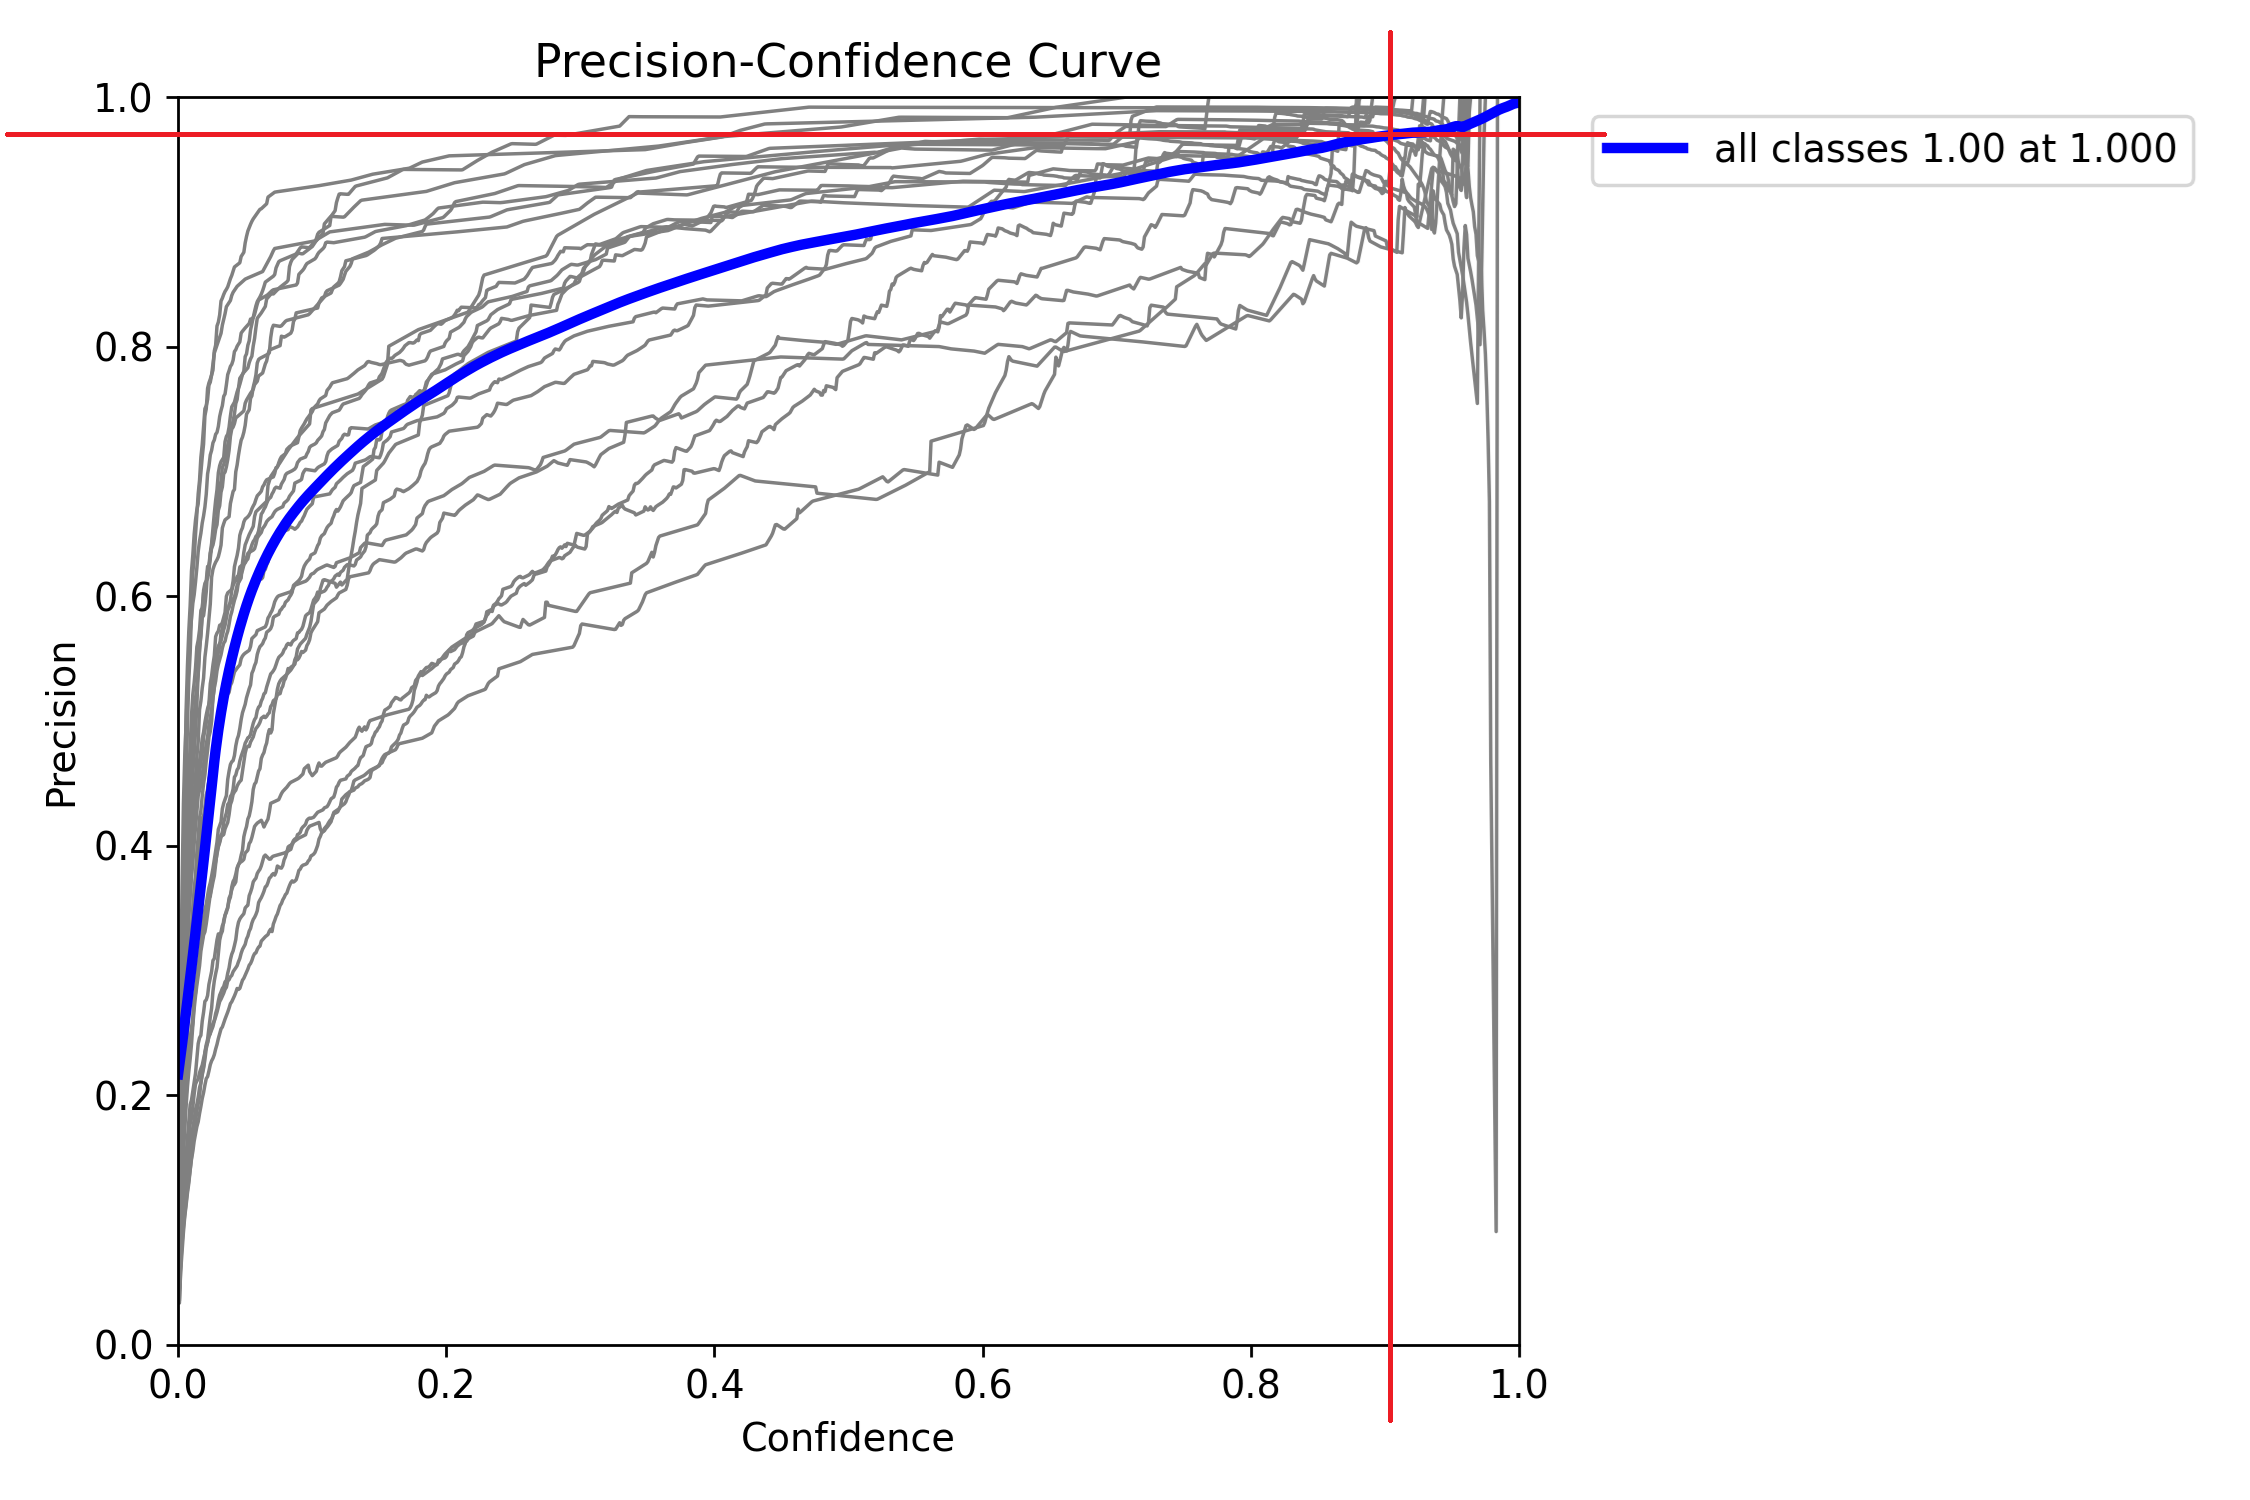

Al analizar el valor del recall con este valor de confianza en la gráfica Recall - Confianza, se observa que el recall alcanza aproximadamente el 50%. Para este caso, es un buen resultado puesto que implica que el modelo detectará el 50% de las partes, y casi el 100% de las predicciones serán correctas.

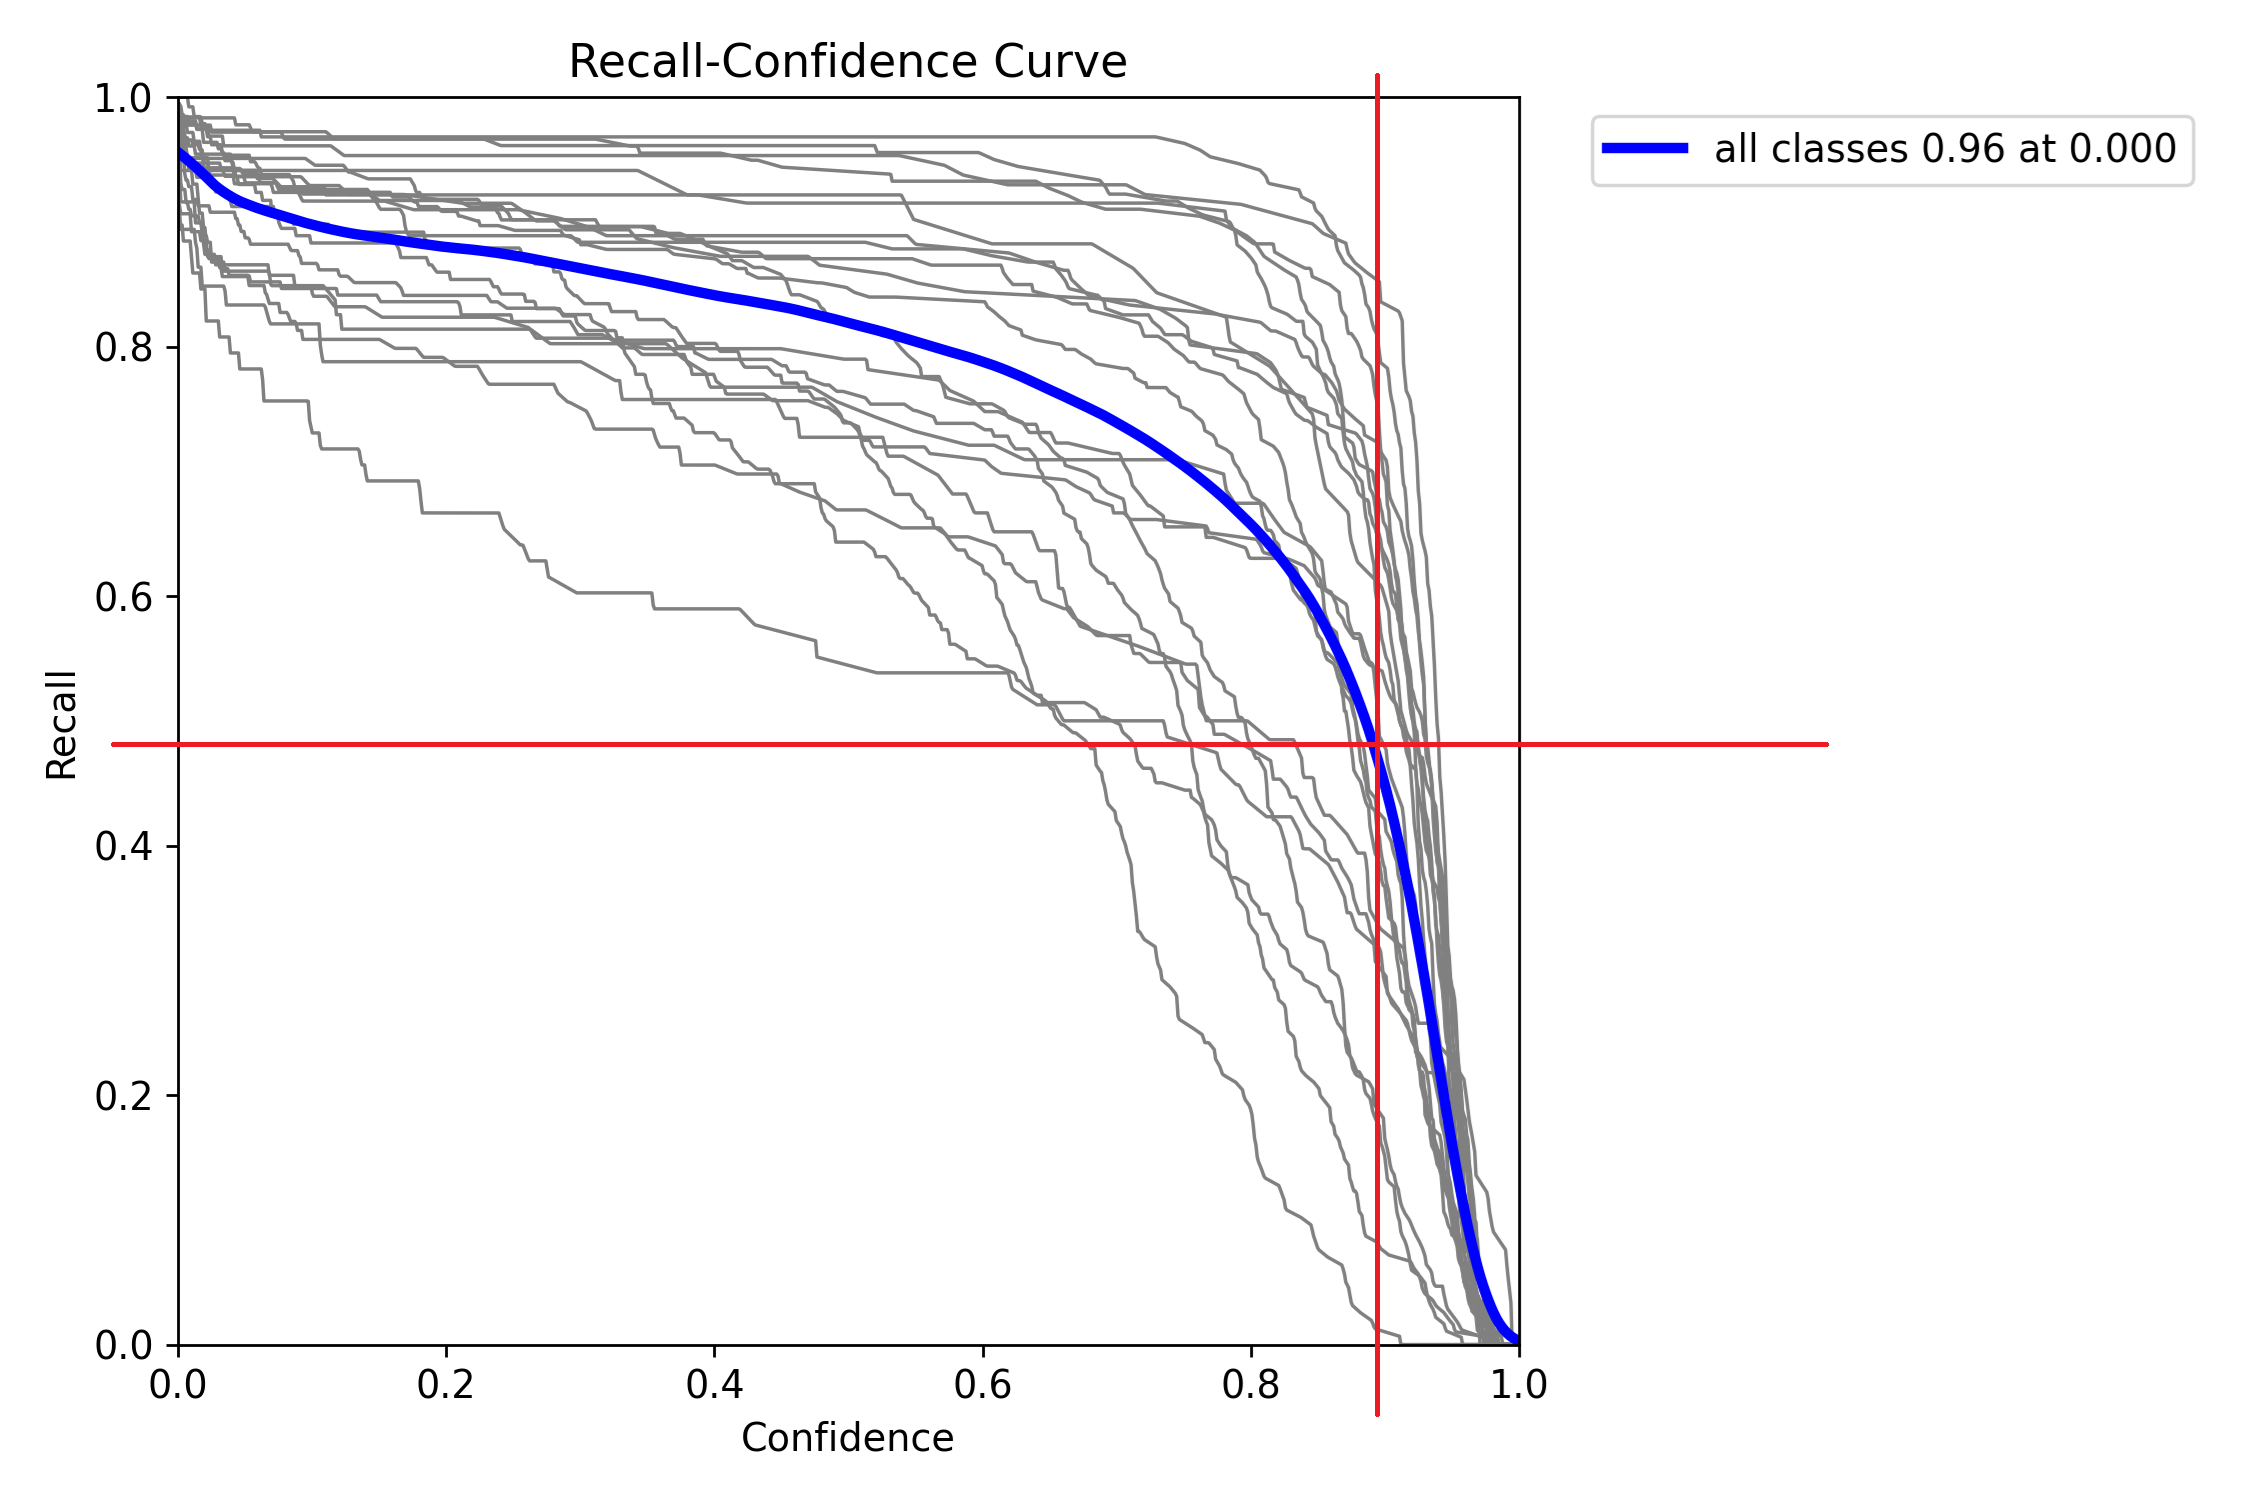